In [224]:
import pandas as pd
from sklearn.metrics import mean_absolute_error
import matplotlib.pyplot as plt
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.metrics import make_scorer
from sklearn.model_selection import cross_validate
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression

In [2]:
gold_recovery_train = pd.read_csv('gold_recovery_train.csv')
gold_recovery_test = pd.read_csv('gold_recovery_test.csv')
gold_recovery_full = pd.read_csv('gold_recovery_full.csv')

In [3]:
gold_recovery_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16860 entries, 0 to 16859
Data columns (total 87 columns):
 #   Column                                              Non-Null Count  Dtype  
---  ------                                              --------------  -----  
 0   date                                                16860 non-null  object 
 1   final.output.concentrate_ag                         16788 non-null  float64
 2   final.output.concentrate_pb                         16788 non-null  float64
 3   final.output.concentrate_sol                        16490 non-null  float64
 4   final.output.concentrate_au                         16789 non-null  float64
 5   final.output.recovery                               15339 non-null  float64
 6   final.output.tail_ag                                16794 non-null  float64
 7   final.output.tail_pb                                16677 non-null  float64
 8   final.output.tail_sol                               16715 non-null  float64


In [4]:
pd.options.display.max_columns = None
pd.set_option('display.max_rows', None)
gold_recovery_train.head()


,date,final.output.concentrate_ag,final.output.concentrate_pb,final.output.concentrate_sol,final.output.concentrate_au,final.output.recovery,final.output.tail_ag,final.output.tail_pb,final.output.tail_sol,final.output.tail_au,primary_cleaner.input.sulfate,primary_cleaner.input.depressant,primary_cleaner.input.feed_size,primary_cleaner.input.xanthate,primary_cleaner.output.concentrate_ag,primary_cleaner.output.concentrate_pb,primary_cleaner.output.concentrate_sol,primary_cleaner.output.concentrate_au,primary_cleaner.output.tail_ag,primary_cleaner.output.tail_pb,primary_cleaner.output.tail_sol,primary_cleaner.output.tail_au,primary_cleaner.state.floatbank8_a_air,primary_cleaner.state.floatbank8_a_level,primary_cleaner.state.floatbank8_b_air,primary_cleaner.state.floatbank8_b_level,primary_cleaner.state.floatbank8_c_air,primary_cleaner.state.floatbank8_c_level,primary_cleaner.state.floatbank8_d_air,primary_cleaner.state.floatbank8_d_level,rougher.calculation.sulfate_to_au_concentrate,rougher.calculation.floatbank10_sulfate_to_au_feed,rougher.calculation.floatbank11_sulfate_to_au_feed,rougher.calculation.au_pb_ratio,rougher.input.feed_ag,rougher.input.feed_pb,rougher.input.feed_rate,rougher.input.feed_size,rougher.input.feed_sol,rougher.input.feed_au,rougher.input.floatbank10_sulfate,rougher.input.floatbank10_xanthate,rougher.input.floatbank11_sulfate,rougher.input.floatbank11_xanthate,rougher.output.concentrate_ag,rougher.output.concentrate_pb,rougher.output.concentrate_sol,rougher.output.concentrate_au,rougher.output.recovery,rougher.output.tail_ag,rougher.output.tail_pb,rougher.output.tail_sol,rougher.output.tail_au,rougher.state.floatbank10_a_air,rougher.state.floatbank10_a_level,rougher.state.floatbank10_b_air,rougher.state.floatbank10_b_level,rougher.state.floatbank10_c_air,rougher.state.floatbank10_c_level,rougher.state.floatbank10_d_air,rougher.state.floatbank10_d_level,rougher.state.floatbank10_e_air,rougher.state.floatbank10_e_level,rougher.state.floatbank10_f_air,rougher.state.floatbank10_f_level,secondary_cleaner.output.tail_ag,secondary_cleaner.output.tail_pb,secondary_cleaner.output.tail_sol,secondary_cleaner.output.tail_au,secondary_cleaner.state.floatbank2_a_air,secondary_cleaner.state.floatbank2_a_level,secondary_cleaner.state.floatbank2_b_air,secondary_cleaner.state.floatbank2_b_level,secondary_cleaner.state.floatbank3_a_air,secondary_cleaner.state.floatbank3_a_level,secondary_cleaner.state.floatbank3_b_air,secondary_cleaner.state.floatbank3_b_level,secondary_cleaner.state.floatbank4_a_air,secondary_cleaner.state.floatbank4_a_level,secondary_cleaner.state.floatbank4_b_air,secondary_cleaner.state.floatbank4_b_level,secondary_cleaner.state.floatbank5_a_air,secondary_cleaner.state.floatbank5_a_level,secondary_cleaner.state.floatbank5_b_air,secondary_cleaner.state.floatbank5_b_level,secondary_cleaner.state.floatbank6_a_air,secondary_cleaner.state.floatbank6_a_level
0,2016-01-15 00:00:00,6.055403,9.889648,5.507324,42.192020,70.541216,10.411962,0.895447,16.904297,2.143149,127.092003,10.128295,7.25,0.988759,8.547551,10.389648,19.529297,34.174427,14.936526,2.534912,7.476074,2.106679,1549.775757,-498.912140,1551.434204,-516.403442,1549.873901,-498.666595,1554.367432,-493.428131,41885.707031,3481.779053,3520.337158,2.838687,6.100378,2.284912,523.546326,55.486599,36.808594,6.486150,11.986616,6.007990,11.836743,6.005818,11.500771,7.101074,28.029297,19.793808,87.107763,5.008018,0.508728,19.154297,1.170244,999.706909,-404.066986,1603.011353,-434.715027,1602.375000,-442.204468,1598.937256,-451.294128,1404.472046,-455.462982,1416.354980,-451.939636,14.500184,4.694824,8.764648,2.606185,25.853109,-498.526489,23.893660,-501.406281,23.961798,-495.262817,21.940409,-499.340973,14.016835,-502.488007,12.099931,-504.715942,9.925633,-498.310211,8.079666,-500.470978,14.151341,-605.841980
1,2016-01-15 01:00:00,6.029369,9.968944,5.257781,42.701629,69.266198,10.462676,0.927452,16.634514,2.224930,125.629232,10.296251,7.25,1.002663,8.558743,10.

Vamos a realizar un conteo de valores 0 en las columnas que conforman la formula para hallar la recuperacion en la fase de flotacion porque al haber datos de valor 0 pueden causar un error matematico al dividir en 0

In [5]:
conteo = gold_recovery_train['rougher.output.concentrate_au'].value_counts()[0]
print(f"El valor '0' aparece {conteo} veces en la columna.")

El valor '0' aparece 1493 veces en la columna.


In [6]:
conteo_2 = gold_recovery_train['rougher.input.feed_au'].value_counts()[0]
print(f"El valor '0' aparece {conteo_2} veces en la columna.")

El valor '0' aparece 1159 veces en la columna.


In [7]:
(gold_recovery_train['rougher.output.tail_au']==0).sum()


np.int64(0)

Al haber 1159 valores 0 en la columna "rougher.input.feed_au" podemos ver que van a haber 1159 veces en que el valor de la recuperacion sera matematicamente un error ya que se dividira en 0 en la formula, asi que si voy a calcular la recuperacion con la ecuacion asignada tendre que exceptuar dichos valores 0.

In [8]:
gold_recovery_train_2 = gold_recovery_train[gold_recovery_train['rougher.input.feed_au']!=0]

Tambien para hallar la recuperacion vamos a filtrar los datos ausentes de las columnas necesarias para el calculo ya que para el procedimiento siguiente del calculo del MAE (Error absoluto medio) no podemos tener valores ausentes.

In [9]:
# Filtramos los datos ausentes de los valores necesarios para hallar la recuperacion
gold_recovery_train_2 = gold_recovery_train_2[(~gold_recovery_train_2['rougher.output.concentrate_au'].isna())&(~gold_recovery_train_2['rougher.output.tail_au'].isna())&(~gold_recovery_train_2['rougher.input.feed_au'].isna())&(~gold_recovery_train_2['rougher.output.recovery'].isna())]

In [10]:
#Revisamos que ya no hay valores 0 en la columna mas critica para hallar la recuperacion
(gold_recovery_train_2['rougher.input.feed_au']==0).sum()

np.int64(0)

In [11]:
#Calculamos la recuperacion en el dataframe de gold_recovery_train
recuperacion_train = ((gold_recovery_train_2['rougher.output.concentrate_au']*(gold_recovery_train_2['rougher.input.feed_au']-gold_recovery_train_2['rougher.output.tail_au']))/(gold_recovery_train_2['rougher.input.feed_au']*(gold_recovery_train_2['rougher.output.concentrate_au']-gold_recovery_train_2['rougher.output.tail_au'])))*100

In [12]:
recuperacion_train

0         87.107763
1         86.843261
2         86.842308
3         87.226430
4         86.688794
5         88.156912
6         88.168065
7         87.668336
8         87.035862
9         87.650868
10        88.280699
11        88.499117
12        89.299981
13        89.519701
14        87.235441
15        85.136294
16        85.443505
17        86.489827
18        85.462226
19        86.241795
20        86.582578
21        86.824119
22        88.132239
23        85.910498
24        86.262377
25        87.561100
26        87.580848
27        87.107693
28        87.431708
29        86.798211
30        88.066903
31        88.804718
32        89.964407
33        86.303989
34        87.298278
35        85.448045
36        87.323840
37        88.151219
38        88.012961
39        85.633837
40        85.017832
41        87.941479
42        86.205601
43        82.078433
44        91.408585
45        -0.000000
46        -0.000000
47        -0.000000
48        -0.000000
49         0.000000


In [13]:
#Verificamos que no hay datos ausentes en el calculo de la recuperacion para posteriormente hallar el MAE
recuperacion_train.isna().sum()

np.int64(0)

In [14]:
gold_recovery_train_2['rougher.output.recovery']

0         87.107763
1         86.843261
2         86.842308
3         87.226430
4         86.688794
5         88.156912
6         88.168065
7         87.668336
8         87.035862
9         87.650868
10        88.280699
11        88.499117
12        89.299981
13        89.519701
14        87.235441
15        85.136294
16        85.443505
17        86.489827
18        85.462226
19        86.241795
20        86.582578
21        86.824119
22        88.132239
23        85.910498
24        86.262377
25        87.561100
26        87.580848
27        87.107693
28        87.431708
29        86.798211
30        88.066903
31        88.804718
32        89.964407
33        86.303989
34        87.298278
35        85.448045
36        87.323840
37        88.151219
38        88.012961
39        85.633837
40        85.017832
41        87.941479
42        86.205601
43        82.078433
44        91.408585
45         0.000000
46         0.000000
47         0.000000
48         0.000000
49         0.000000


In [15]:
#verificamos que no hay valores ausentes en la columna de "rougher.output.recovery" con la que vamos a hallar el MAE 
gold_recovery_train_2['rougher.output.recovery'].isna().sum()

np.int64(0)

In [16]:
print(mean_absolute_error(gold_recovery_train_2['rougher.output.recovery'],recuperacion_train))

9.303415616264301e-15


podemos ver que El Error Absoluto Medio es muy pequeño por lo tanto los valores en la columna "rougher.output.recovery" estan bien calculados

In [17]:
#vemos la informacion que se encuentra en la tabla "gold_recovery_test" para ver si los datos estan completos como en los otros datasets
gold_recovery_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5856 entries, 0 to 5855
Data columns (total 53 columns):
 #   Column                                      Non-Null Count  Dtype  
---  ------                                      --------------  -----  
 0   date                                        5856 non-null   object 
 1   primary_cleaner.input.sulfate               5554 non-null   float64
 2   primary_cleaner.input.depressant            5572 non-null   float64
 3   primary_cleaner.input.feed_size             5856 non-null   float64
 4   primary_cleaner.input.xanthate              5690 non-null   float64
 5   primary_cleaner.state.floatbank8_a_air      5840 non-null   float64
 6   primary_cleaner.state.floatbank8_a_level    5840 non-null   float64
 7   primary_cleaner.state.floatbank8_b_air      5840 non-null   float64
 8   primary_cleaner.state.floatbank8_b_level    5840 non-null   float64
 9   primary_cleaner.state.floatbank8_c_air      5840 non-null   float64
 10  primary_clea

In [18]:
# Hallamos las columnas que no tiene el dataframe "gold_recovery_test" y si estan en el dataframe "gold_recovery_full"
# Obtener los nombres de las columnas como listas
cols_full= list(gold_recovery_full.columns)
cols_test = list(gold_recovery_test.columns)

# Comparar listas de columnas
cols_unique_test = [col for col in cols_full if col not in cols_test]

print(cols_unique_test)

['final.output.concentrate_ag', 'final.output.concentrate_pb', 'final.output.concentrate_sol', 'final.output.concentrate_au', 'final.output.recovery', 'final.output.tail_ag', 'final.output.tail_pb', 'final.output.tail_sol', 'final.output.tail_au', 'primary_cleaner.output.concentrate_ag', 'primary_cleaner.output.concentrate_pb', 'primary_cleaner.output.concentrate_sol', 'primary_cleaner.output.concentrate_au', 'primary_cleaner.output.tail_ag', 'primary_cleaner.output.tail_pb', 'primary_cleaner.output.tail_sol', 'primary_cleaner.output.tail_au', 'rougher.calculation.sulfate_to_au_concentrate', 'rougher.calculation.floatbank10_sulfate_to_au_feed', 'rougher.calculation.floatbank11_sulfate_to_au_feed', 'rougher.calculation.au_pb_ratio', 'rougher.output.concentrate_ag', 'rougher.output.concentrate_pb', 'rougher.output.concentrate_sol', 'rougher.output.concentrate_au', 'rougher.output.recovery', 'rougher.output.tail_ag', 'rougher.output.tail_pb', 'rougher.output.tail_sol', 'rougher.output.tai

Todos los datos faltante en el dataframe gold_recovery_test son del tipo Float y pertenecen a las salidas de concentraciones de los elementos para limpiar la materia prima de oro, tambien a las salidas de las colas de todo los materiales que salen al final, y la recuperacion final de oro en cada una de las etapas de procesamiento para la extraccion del oro. Ademas tambien faltan caracteristicas de calculo de sulfato a concentrado de oro en la etapa de flotacion y tambien caracteristicas de calculos de sulfato a concentrado de oro en instalacion de de flotacion numero 10 y 11. Si vamos a usar este dataframe para testear el modelo haria falta hacer un procedimiento de union para tener la informacion faltante para el test del modelo. 

In [19]:
gold_recovery_train.isna().sum()

date                                                     0
final.output.concentrate_ag                             72
final.output.concentrate_pb                             72
final.output.concentrate_sol                           370
final.output.concentrate_au                             71
final.output.recovery                                 1521
final.output.tail_ag                                    66
final.output.tail_pb                                   183
final.output.tail_sol                                  145
final.output.tail_au                                    66
primary_cleaner.input.sulfate                         1307
primary_cleaner.input.depressant                      1262
primary_cleaner.input.feed_size                          0
primary_cleaner.input.xanthate                         985
primary_cleaner.output.concentrate_ag                   82
primary_cleaner.output.concentrate_pb                  358
primary_cleaner.output.concentrate_sol                 6

In [20]:
gold_recovery_train.duplicated().sum()

np.int64(0)

Podemos ver que todo los tres dataframes tienen multiples datos ausentes en diferentes columnas. Para solucionar este problema primero veremos la distribucion de cada dataframe con describe y realizaremos una imputacion con interpolacion linear y veremos si hay un cambio muy grande en la distribucion de datos asi si no hay un cambio muy grande seguiremos con el procedimiento de analisis de datos y entrenamiento del modelo

In [21]:
gold_recovery_train['date'] =  pd.to_datetime(gold_recovery_train['date'], format ='%Y-%m-%d %H:%M:%S')
gold_recovery_train.describe()

,date,final.output.concentrate_ag,final.output.concentrate_pb,final.output.concentrate_sol,final.output.concentrate_au,final.output.recovery,final.output.tail_ag,final.output.tail_pb,final.output.tail_sol,final.output.tail_au,primary_cleaner.input.sulfate,primary_cleaner.input.depressant,primary_cleaner.input.feed_size,primary_cleaner.input.xanthate,primary_cleaner.output.concentrate_ag,primary_cleaner.output.concentrate_pb,primary_cleaner.output.concentrate_sol,primary_cleaner.output.concentrate_au,primary_cleaner.output.tail_ag,primary_cleaner.output.tail_pb,primary_cleaner.output.tail_sol,primary_cleaner.output.tail_au,primary_cleaner.state.floatbank8_a_air,primary_cleaner.state.floatbank8_a_level,primary_cleaner.state.floatbank8_b_air,primary_cleaner.state.floatbank8_b_level,primary_cleaner.state.floatbank8_c_air,primary_cleaner.state.floatbank8_c_level,primary_cleaner.state.floatbank8_d_air,primary_cleaner.state.floatbank8_d_level,rougher.calculation.sulfate_to_au_concentrate,rougher.calculation.floatbank10_sulfate_to_au_feed,rougher.calculation.floatbank11_sulfate_to_au_feed,rougher.calculation.au_pb_ratio,rougher.input.feed_ag,rougher.input.feed_pb,rougher.input.feed_rate,rougher.input.feed_size,rougher.input.feed_sol,rougher.input.feed_au,rougher.input.floatbank10_sulfate,rougher.input.floatbank10_xanthate,rougher.input.floatbank11_sulfate,rougher.input.floatbank11_xanthate,rougher.output.concentrate_ag,rougher.output.concentrate_pb,rougher.output.concentrate_sol,rougher.output.concentrate_au,rougher.output.recovery,rougher.output.tail_ag,rougher.output.tail_pb,rougher.output.tail_sol,rougher.output.tail_au,rougher.state.floatbank10_a_air,rougher.state.floatbank10_a_level,rougher.state.floatbank10_b_air,rougher.state.floatbank10_b_level,rougher.state.floatbank10_c_air,rougher.state.floatbank10_c_level,rougher.state.floatbank10_d_air,rougher.state.floatbank10_d_level,rougher.state.floatbank10_e_air,rougher.state.floatbank10_e_level,rougher.state.floatbank10_f_air,rougher.state.floatbank10_f_level,secondary_cleaner.output.tail_ag,secondary_cleaner.output.tail_pb,secondary_cleaner.output.tail_sol,secondary_cleaner.output.tail_au,secondary_cleaner.state.floatbank2_a_air,secondary_cleaner.state.floatbank2_a_level,secondary_cleaner.state.floatbank2_b_air,secondary_cleaner.state.floatbank2_b_level,secondary_cleaner.state.floatbank3_a_air,secondary_cleaner.state.floatbank3_a_level,secondary_cleaner.state.floatbank3_b_air,secondary_cleaner.state.floatbank3_b_level,secondary_cleaner.state.floatbank4_a_air,secondary_cleaner.state.floatbank4_a_level,secondary_cleaner.state.floatbank4_b_air,secondary_cleaner.state.floatbank4_b_level,secondary_cleaner.state.floatbank5_a_air,secondary_cleaner.state.floatbank5_a_level,secondary_cleaner.state.floatbank5_b_air,secondary_cleaner.state.floatbank5_b_level,secondary_cleaner.state.floatbank6_a_air,secondary_cleaner.state.floatbank6_a_level
count,16860,16788.000000,16788.000000,16490.000000,16789.000000,15339.000000,16794.000000,16677.000000,16715.000000,16794.000000,15553.000000,15598.000000,16860.000000,15875.000000,16778.000000,16502.000000,16224.000000,16778.000000,16777.000000,16761.000000,16579.000000,16777.000000,16820.000000,16827.000000,16820.000000,16833.000000,16822.000000,16833.000000,16821.000000,16833.000000,1.683300e+04,1.683300e+04,1.683300e+04,15618.000000,16778.000000,16632.000000,16347.000000,16443.000000,16568.000000,16777.000000,15816.000000,16514.000000,16237.000000,14956.000000,16778.000000,16778.000000,16698.000000,16778.000000,14287.000000,14610.000000,16778.000000,14611.000000,14611.000000,16807.000000,16807.000000,16807.000000,16807.000000,16807.000000,16814.000000,16802.000000,16809.000000,16257.000000,16809.000000,16802.000000,16802.000000,16776.000000,16764.000000,14874.000000,16778.000000,16497.000000,16751.000000,16705.000000,16748.000000,16763.000000,16747.000000,16752.000000,16750.000000,16731.000000,16747.000000,16768.000000,16767.000000,16775.000000,16775.0

Para el procesamiento de datos en la ausencia de datos se usara la imputacion mas exactamente la interpolacion lineal ya que los datos de las tres tablas que nos han dado son del tipo Time Series, o que estan fuertemente relacionados los datos cercanos por fechas y el metodo de interpolacion lineal es uno de los mas eficientes para este proceso

In [22]:
gold_recovery_train_interpolate= gold_recovery_train.interpolate(method='linear')

In [23]:
gold_recovery_train_interpolate.describe()

,date,final.output.concentrate_ag,final.output.concentrate_pb,final.output.concentrate_sol,final.output.concentrate_au,final.output.recovery,final.output.tail_ag,final.output.tail_pb,final.output.tail_sol,final.output.tail_au,primary_cleaner.input.sulfate,primary_cleaner.input.depressant,primary_cleaner.input.feed_size,primary_cleaner.input.xanthate,primary_cleaner.output.concentrate_ag,primary_cleaner.output.concentrate_pb,primary_cleaner.output.concentrate_sol,primary_cleaner.output.concentrate_au,primary_cleaner.output.tail_ag,primary_cleaner.output.tail_pb,primary_cleaner.output.tail_sol,primary_cleaner.output.tail_au,primary_cleaner.state.floatbank8_a_air,primary_cleaner.state.floatbank8_a_level,primary_cleaner.state.floatbank8_b_air,primary_cleaner.state.floatbank8_b_level,primary_cleaner.state.floatbank8_c_air,primary_cleaner.state.floatbank8_c_level,primary_cleaner.state.floatbank8_d_air,primary_cleaner.state.floatbank8_d_level,rougher.calculation.sulfate_to_au_concentrate,rougher.calculation.floatbank10_sulfate_to_au_feed,rougher.calculation.floatbank11_sulfate_to_au_feed,rougher.calculation.au_pb_ratio,rougher.input.feed_ag,rougher.input.feed_pb,rougher.input.feed_rate,rougher.input.feed_size,rougher.input.feed_sol,rougher.input.feed_au,rougher.input.floatbank10_sulfate,rougher.input.floatbank10_xanthate,rougher.input.floatbank11_sulfate,rougher.input.floatbank11_xanthate,rougher.output.concentrate_ag,rougher.output.concentrate_pb,rougher.output.concentrate_sol,rougher.output.concentrate_au,rougher.output.recovery,rougher.output.tail_ag,rougher.output.tail_pb,rougher.output.tail_sol,rougher.output.tail_au,rougher.state.floatbank10_a_air,rougher.state.floatbank10_a_level,rougher.state.floatbank10_b_air,rougher.state.floatbank10_b_level,rougher.state.floatbank10_c_air,rougher.state.floatbank10_c_level,rougher.state.floatbank10_d_air,rougher.state.floatbank10_d_level,rougher.state.floatbank10_e_air,rougher.state.floatbank10_e_level,rougher.state.floatbank10_f_air,rougher.state.floatbank10_f_level,secondary_cleaner.output.tail_ag,secondary_cleaner.output.tail_pb,secondary_cleaner.output.tail_sol,secondary_cleaner.output.tail_au,secondary_cleaner.state.floatbank2_a_air,secondary_cleaner.state.floatbank2_a_level,secondary_cleaner.state.floatbank2_b_air,secondary_cleaner.state.floatbank2_b_level,secondary_cleaner.state.floatbank3_a_air,secondary_cleaner.state.floatbank3_a_level,secondary_cleaner.state.floatbank3_b_air,secondary_cleaner.state.floatbank3_b_level,secondary_cleaner.state.floatbank4_a_air,secondary_cleaner.state.floatbank4_a_level,secondary_cleaner.state.floatbank4_b_air,secondary_cleaner.state.floatbank4_b_level,secondary_cleaner.state.floatbank5_a_air,secondary_cleaner.state.floatbank5_a_level,secondary_cleaner.state.floatbank5_b_air,secondary_cleaner.state.floatbank5_b_level,secondary_cleaner.state.floatbank6_a_air,secondary_cleaner.state.floatbank6_a_level
count,16860,16860.000000,16860.000000,16860.000000,16860.000000,16860.000000,16860.000000,16860.000000,16860.000000,16860.000000,16860.000000,16860.000000,16860.000000,16860.000000,16860.000000,16860.000000,16860.000000,16860.000000,16860.000000,16860.000000,16860.000000,16860.000000,16860.000000,16860.000000,16860.000000,16860.000000,16860.000000,16860.000000,16860.000000,16860.000000,1.686000e+04,1.686000e+04,1.686000e+04,16860.000000,16860.000000,16860.000000,16860.000000,16860.000000,16860.000000,16860.000000,16860.000000,16860.000000,16860.000000,16860.000000,16860.000000,16860.000000,16860.000000,16860.000000,16860.000000,16860.000000,16860.000000,16860.000000,16860.000000,16860.000000,16860.000000,16860.000000,16860.000000,16860.000000,16860.000000,16860.000000,16860.000000,16860.000000,16860.000000,16860.000000,16860.000000,16860.000000,16860.000000,16860.000000,16860.000000,16860.000000,16860.000000,16860.000000,16860.000000,16860.000000,16860.000000,16860.000000,16860.000000,16860.000000,16860.000000,16860.000000,16860.000000,16860.000000,16860.0

Podemos ver que los valores como la media y la desviacion estandar tienen cambios muy pequeños en la gran mayoria de las columnas, esto es causado porque en la gran mayoria de las columnas hay poco porcentaje de datos ausentes. En la columna con mayor cantidad de datos ausentes "rougher.output.recovery" con mas del 15% (2573 datos ausencentes) la variacion en la media y en la desviacion estandar es de 2 unidades, esto puede ser causado por como la interpolacion lineal esta completando los datos de esta columna que al observar los percentiles el mayor cambio en ellos son del percentil 25, por lo que parece que la mayoria de valores ausentes se completaron en esta parte de los valores.

Puede que esta diferencia en la media y desviacion estandar alteren como el modelo capte los datos para ser entrenado y para dar predicciones, pero al ser conciderados aceptable, el cambio se puede conciderar que el entrenamiento y predicciones del modelo no seran muy afectados con repecto a los datos iniciales.

In [24]:
gold_recovery_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5856 entries, 0 to 5855
Data columns (total 53 columns):
 #   Column                                      Non-Null Count  Dtype  
---  ------                                      --------------  -----  
 0   date                                        5856 non-null   object 
 1   primary_cleaner.input.sulfate               5554 non-null   float64
 2   primary_cleaner.input.depressant            5572 non-null   float64
 3   primary_cleaner.input.feed_size             5856 non-null   float64
 4   primary_cleaner.input.xanthate              5690 non-null   float64
 5   primary_cleaner.state.floatbank8_a_air      5840 non-null   float64
 6   primary_cleaner.state.floatbank8_a_level    5840 non-null   float64
 7   primary_cleaner.state.floatbank8_b_air      5840 non-null   float64
 8   primary_cleaner.state.floatbank8_b_level    5840 non-null   float64
 9   primary_cleaner.state.floatbank8_c_air      5840 non-null   float64
 10  primary_clea

In [25]:
gold_recovery_test.isna().sum()

date                                            0
primary_cleaner.input.sulfate                 302
primary_cleaner.input.depressant              284
primary_cleaner.input.feed_size                 0
primary_cleaner.input.xanthate                166
primary_cleaner.state.floatbank8_a_air         16
primary_cleaner.state.floatbank8_a_level       16
primary_cleaner.state.floatbank8_b_air         16
primary_cleaner.state.floatbank8_b_level       16
primary_cleaner.state.floatbank8_c_air         16
primary_cleaner.state.floatbank8_c_level       16
primary_cleaner.state.floatbank8_d_air         16
primary_cleaner.state.floatbank8_d_level       16
rougher.input.feed_ag                          16
rougher.input.feed_pb                          16
rougher.input.feed_rate                        40
rougher.input.feed_size                        22
rougher.input.feed_sol                         67
rougher.input.feed_au                          16
rougher.input.floatbank10_sulfate             257


In [26]:
gold_recovery_test.duplicated().sum()

np.int64(0)

In [27]:
gold_recovery_test['date'] =  pd.to_datetime(gold_recovery_test['date'], format ='%Y-%m-%d %H:%M:%S')
gold_recovery_test.describe()

,date,primary_cleaner.input.sulfate,primary_cleaner.input.depressant,primary_cleaner.input.feed_size,primary_cleaner.input.xanthate,primary_cleaner.state.floatbank8_a_air,primary_cleaner.state.floatbank8_a_level,primary_cleaner.state.floatbank8_b_air,primary_cleaner.state.floatbank8_b_level,primary_cleaner.state.floatbank8_c_air,primary_cleaner.state.floatbank8_c_level,primary_cleaner.state.floatbank8_d_air,primary_cleaner.state.floatbank8_d_level,rougher.input.feed_ag,rougher.input.feed_pb,rougher.input.feed_rate,rougher.input.feed_size,rougher.input.feed_sol,rougher.input.feed_au,rougher.input.floatbank10_sulfate,rougher.input.floatbank10_xanthate,rougher.input.floatbank11_sulfate,rougher.input.floatbank11_xanthate,rougher.state.floatbank10_a_air,rougher.state.floatbank10_a_level,rougher.state.floatbank10_b_air,rougher.state.floatbank10_b_level,rougher.state.floatbank10_c_air,rougher.state.floatbank10_c_level,rougher.state.floatbank10_d_air,rougher.state.floatbank10_d_level,rougher.state.floatbank10_e_air,rougher.state.floatbank10_e_level,rougher.state.floatbank10_f_air,rougher.state.floatbank10_f_level,secondary_cleaner.state.floatbank2_a_air,secondary_cleaner.state.floatbank2_a_level,secondary_cleaner.state.floatbank2_b_air,secondary_cleaner.state.floatbank2_b_level,secondary_cleaner.state.floatbank3_a_air,secondary_cleaner.state.floatbank3_a_level,secondary_cleaner.state.floatbank3_b_air,secondary_cleaner.state.floatbank3_b_level,secondary_cleaner.state.floatbank4_a_air,secondary_cleaner.state.floatbank4_a_level,secondary_cleaner.state.floatbank4_b_air,secondary_cleaner.state.floatbank4_b_level,secondary_cleaner.state.floatbank5_a_air,secondary_cleaner.state.floatbank5_a_level,secondary_cleaner.state.floatbank5_b_air,secondary_cleaner.state.floatbank5_b_level,secondary_cleaner.state.floatbank6_a_air,secondary_cleaner.state.floatbank6_a_level
count,5856,5554.000000,5572.000000,5856.000000,5690.000000,5840.000000,5840.000000,5840.000000,5840.000000,5840.000000,5840.000000,5840.000000,5840.000000,5840.000000,5840.000000,5816.000000,5834.000000,5789.000000,5840.000000,5599.000000,5733.000000,5801.000000,5503.000000,5839.000000,5840.000000,5839.000000,5840.000000,5839.000000,5840.000000,5839.000000,5840.000000,5839.000000,5840.000000,5839.000000,5840.000000,5836.000000,5840.000000,5833.000000,5840.000000,5822.000000,5840.000000,5840.000000,5840.000000,5840.000000,5840.000000,5840.000000,5840.000000,5840.000000,5840.000000,5840.000000,5840.000000,5840.000000,5840.000000
mean,2017-05-02 12:29:59.000000256,170.515243,8.482873,7.264651,1.321420,1481.990241,-509.057796,1486.908670,-511.743956,1468.495216,-509.741212,1486.398557,-510.723606,8.736170,3.552722,458.485472,55.937535,35.105834,8.700930,13.439933,6.169553,13.056047,6.423566,1016.294703,-404.977728,1270.598553,-482.154567,1253.495045,-480.945868,1169.675564,-482.152253,1018.386311,-476.551547,962.005375,-477.795380,25.479808,-513.714941,21.083475,-512.325717,24.345831,-519.417733,20.068079,-515.028316,15.636031,-516.266074,13.145702,-476.338907,12.308967,-512.208126,9.470986,-505.017827,16.678722,-512.351694
min,2016-09-01 00:59:59,0.000103,0.000031,5.650000,0.000003,0.000000,-799.773788,0.000000,-800.029078,0.000000,-799.995127,0.000000,-799.838846,0.000000,0.000000,0.002986,0.046369,0.000000,0.000000,0.000154,0.000052,0.000014,0.000055,-0.123194,-657.949759,-0.821921,-650.349159,-0.282087,-650.000000,-1.047388,-648.390665,-2.076798,-650.152533,-2.593390,-650.034631,0.000000,-799.608557,0.000000,-798.467243,0.000000,-799.755798,0.000000,-809.333008,0.000000,-799.798523,0.000000,-800.836914,-0.223393,-799.661076,0.528083,-800.220337,-0.079426,-809.859706
25%,2016-11-01 00:44:59,143.340022,6.411500,6.885625,0.888769,1497.190681,-500.455211,1497.150234,-500.936639,1437.050321,-501.300441,1498.407528,-500.553630,7.598683,3.079145,399.781738,43.890852,33.381580,7.763634,11.006487,5.884416,10.999216,5.994363,998.970605,-499.971279,1199.500725,-500.327705,1195.460415,-500.310780

In [28]:
gold_recovery_test_interpolate  = gold_recovery_test.interpolate(method='linear')

In [29]:
gold_recovery_test_interpolate.describe()

,date,primary_cleaner.input.sulfate,primary_cleaner.input.depressant,primary_cleaner.input.feed_size,primary_cleaner.input.xanthate,primary_cleaner.state.floatbank8_a_air,primary_cleaner.state.floatbank8_a_level,primary_cleaner.state.floatbank8_b_air,primary_cleaner.state.floatbank8_b_level,primary_cleaner.state.floatbank8_c_air,primary_cleaner.state.floatbank8_c_level,primary_cleaner.state.floatbank8_d_air,primary_cleaner.state.floatbank8_d_level,rougher.input.feed_ag,rougher.input.feed_pb,rougher.input.feed_rate,rougher.input.feed_size,rougher.input.feed_sol,rougher.input.feed_au,rougher.input.floatbank10_sulfate,rougher.input.floatbank10_xanthate,rougher.input.floatbank11_sulfate,rougher.input.floatbank11_xanthate,rougher.state.floatbank10_a_air,rougher.state.floatbank10_a_level,rougher.state.floatbank10_b_air,rougher.state.floatbank10_b_level,rougher.state.floatbank10_c_air,rougher.state.floatbank10_c_level,rougher.state.floatbank10_d_air,rougher.state.floatbank10_d_level,rougher.state.floatbank10_e_air,rougher.state.floatbank10_e_level,rougher.state.floatbank10_f_air,rougher.state.floatbank10_f_level,secondary_cleaner.state.floatbank2_a_air,secondary_cleaner.state.floatbank2_a_level,secondary_cleaner.state.floatbank2_b_air,secondary_cleaner.state.floatbank2_b_level,secondary_cleaner.state.floatbank3_a_air,secondary_cleaner.state.floatbank3_a_level,secondary_cleaner.state.floatbank3_b_air,secondary_cleaner.state.floatbank3_b_level,secondary_cleaner.state.floatbank4_a_air,secondary_cleaner.state.floatbank4_a_level,secondary_cleaner.state.floatbank4_b_air,secondary_cleaner.state.floatbank4_b_level,secondary_cleaner.state.floatbank5_a_air,secondary_cleaner.state.floatbank5_a_level,secondary_cleaner.state.floatbank5_b_air,secondary_cleaner.state.floatbank5_b_level,secondary_cleaner.state.floatbank6_a_air,secondary_cleaner.state.floatbank6_a_level
count,5856,5856.000000,5856.000000,5856.000000,5856.000000,5856.000000,5856.000000,5856.000000,5856.000000,5856.000000,5856.000000,5856.000000,5856.000000,5856.000000,5856.000000,5856.000000,5856.000000,5856.000000,5856.000000,5856.000000,5856.000000,5856.000000,5856.000000,5856.000000,5856.000000,5856.000000,5856.000000,5856.000000,5856.000000,5856.000000,5856.000000,5856.000000,5856.000000,5856.000000,5856.000000,5856.000000,5856.000000,5856.000000,5856.000000,5856.000000,5856.000000,5856.000000,5856.000000,5856.000000,5856.000000,5856.000000,5856.000000,5856.000000,5856.000000,5856.000000,5856.000000,5856.000000,5856.000000
mean,2017-05-02 12:29:59.000000256,164.804907,8.166684,7.264651,1.288419,1481.929746,-509.137533,1486.908035,-511.817526,1468.549653,-509.815837,1486.402768,-510.795296,8.736767,3.553710,456.983440,55.886800,34.957923,8.701742,12.978213,6.073253,12.972052,6.159852,1015.737942,-405.288375,1270.257914,-482.254827,1253.202900,-481.046588,1169.628380,-482.243797,1017.938949,-476.667721,961.484705,-477.914082,25.480889,-513.779446,21.093127,-512.389641,24.319538,-519.459749,20.087284,-515.051594,15.633995,-516.314342,13.145633,-476.506662,12.306731,-512.277180,9.474125,-505.107479,16.683375,-512.414761
min,2016-09-01 00:59:59,0.000103,0.000031,5.650000,0.000003,0.000000,-799.773788,0.000000,-800.029078,0.000000,-799.995127,0.000000,-799.838846,0.000000,0.000000,0.002986,0.046369,0.000000,0.000000,0.000154,0.000052,0.000014,0.000055,-0.123194,-657.949759,-0.821921,-650.349159,-0.282087,-650.000000,-1.047388,-648.390665,-2.076798,-650.152533,-2.593390,-650.034631,0.000000,-799.608557,0.000000,-798.467243,0.000000,-799.755798,0.000000,-809.333008,0.000000,-799.798523,0.000000,-800.836914,-0.223393,-799.661076,0.528083,-800.220337,-0.079426,-809.859706
25%,2016-11-01 00:44:59,138.451274,6.017156,6.885625,0.849801,1497.219854,-500.460409,1497.171993,-500.956595,1437.697158,-501.296518,1498.416501,-500.552708,7.601568,3.081297,399.502776,43.865121,33.208824,7.765897,10.992685,5.801882,10.998130,5.801349,998.970923,-499.970911,1199.525959,-500.327323,1195.525137,-500.311728

Se puede observar que al aplicar la innterpolacion lineal algunos valores de media y desviacion estandar cambiaron en mayor grado unos que otros pero la gran mayoria se mantuvieron en un cambio de valores decimales excepto el de la columna "primary_cleaner.input.sulfate" que hubo un gran cambio casi 6 unidades en la media y mas de 7 unidades en la desviacion estandar, esto es causado como en el proceso anterior con el dataset de train por el numero de valores ausentes y su distribucion, que en el caso de esta columna es la segunda mayor cantidad de ausencias del dataset, esto podria alterar el entrenamiento y las predicciones del modelo, aunque se ve que la distribucion de los valores ausentes se mantuvieron en su mayoria en el percentil 25 en los demas percentiles tambien hubo cambios que podrian ser aceptables para el procesamiento de datos y para el modelo.

In [30]:
gold_recovery_full['date'] = pd.to_datetime(gold_recovery_full['date'], format= '%Y-%m-%d %H:%M:%S')
gold_recovery_full.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 22716 entries, 0 to 22715
Data columns (total 87 columns):
 #   Column                                              Non-Null Count  Dtype         
---  ------                                              --------------  -----         
 0   date                                                22716 non-null  datetime64[ns]
 1   final.output.concentrate_ag                         22627 non-null  float64       
 2   final.output.concentrate_pb                         22629 non-null  float64       
 3   final.output.concentrate_sol                        22331 non-null  float64       
 4   final.output.concentrate_au                         22630 non-null  float64       
 5   final.output.recovery                               20753 non-null  float64       
 6   final.output.tail_ag                                22633 non-null  float64       
 7   final.output.tail_pb                                22516 non-null  float64       
 8   final.

In [31]:
gold_recovery_full.isna().sum()

date                                                     0
final.output.concentrate_ag                             89
final.output.concentrate_pb                             87
final.output.concentrate_sol                           385
final.output.concentrate_au                             86
final.output.recovery                                 1963
final.output.tail_ag                                    83
final.output.tail_pb                                   200
final.output.tail_sol                                  271
final.output.tail_au                                    81
primary_cleaner.input.sulfate                         1609
primary_cleaner.input.depressant                      1546
primary_cleaner.input.feed_size                          0
primary_cleaner.input.xanthate                        1151
primary_cleaner.output.concentrate_ag                   98
primary_cleaner.output.concentrate_pb                  448
primary_cleaner.output.concentrate_sol                 7

In [32]:
gold_recovery_full.duplicated().sum()

np.int64(0)

In [33]:
gold_recovery_full.describe()

,date,final.output.concentrate_ag,final.output.concentrate_pb,final.output.concentrate_sol,final.output.concentrate_au,final.output.recovery,final.output.tail_ag,final.output.tail_pb,final.output.tail_sol,final.output.tail_au,primary_cleaner.input.sulfate,primary_cleaner.input.depressant,primary_cleaner.input.feed_size,primary_cleaner.input.xanthate,primary_cleaner.output.concentrate_ag,primary_cleaner.output.concentrate_pb,primary_cleaner.output.concentrate_sol,primary_cleaner.output.concentrate_au,primary_cleaner.output.tail_ag,primary_cleaner.output.tail_pb,primary_cleaner.output.tail_sol,primary_cleaner.output.tail_au,primary_cleaner.state.floatbank8_a_air,primary_cleaner.state.floatbank8_a_level,primary_cleaner.state.floatbank8_b_air,primary_cleaner.state.floatbank8_b_level,primary_cleaner.state.floatbank8_c_air,primary_cleaner.state.floatbank8_c_level,primary_cleaner.state.floatbank8_d_air,primary_cleaner.state.floatbank8_d_level,rougher.calculation.sulfate_to_au_concentrate,rougher.calculation.floatbank10_sulfate_to_au_feed,rougher.calculation.floatbank11_sulfate_to_au_feed,rougher.calculation.au_pb_ratio,rougher.input.feed_ag,rougher.input.feed_pb,rougher.input.feed_rate,rougher.input.feed_size,rougher.input.feed_sol,rougher.input.feed_au,rougher.input.floatbank10_sulfate,rougher.input.floatbank10_xanthate,rougher.input.floatbank11_sulfate,rougher.input.floatbank11_xanthate,rougher.output.concentrate_ag,rougher.output.concentrate_pb,rougher.output.concentrate_sol,rougher.output.concentrate_au,rougher.output.recovery,rougher.output.tail_ag,rougher.output.tail_pb,rougher.output.tail_sol,rougher.output.tail_au,rougher.state.floatbank10_a_air,rougher.state.floatbank10_a_level,rougher.state.floatbank10_b_air,rougher.state.floatbank10_b_level,rougher.state.floatbank10_c_air,rougher.state.floatbank10_c_level,rougher.state.floatbank10_d_air,rougher.state.floatbank10_d_level,rougher.state.floatbank10_e_air,rougher.state.floatbank10_e_level,rougher.state.floatbank10_f_air,rougher.state.floatbank10_f_level,secondary_cleaner.output.tail_ag,secondary_cleaner.output.tail_pb,secondary_cleaner.output.tail_sol,secondary_cleaner.output.tail_au,secondary_cleaner.state.floatbank2_a_air,secondary_cleaner.state.floatbank2_a_level,secondary_cleaner.state.floatbank2_b_air,secondary_cleaner.state.floatbank2_b_level,secondary_cleaner.state.floatbank3_a_air,secondary_cleaner.state.floatbank3_a_level,secondary_cleaner.state.floatbank3_b_air,secondary_cleaner.state.floatbank3_b_level,secondary_cleaner.state.floatbank4_a_air,secondary_cleaner.state.floatbank4_a_level,secondary_cleaner.state.floatbank4_b_air,secondary_cleaner.state.floatbank4_b_level,secondary_cleaner.state.floatbank5_a_air,secondary_cleaner.state.floatbank5_a_level,secondary_cleaner.state.floatbank5_b_air,secondary_cleaner.state.floatbank5_b_level,secondary_cleaner.state.floatbank6_a_air,secondary_cleaner.state.floatbank6_a_level
count,22716,22627.000000,22629.000000,22331.000000,22630.000000,20753.000000,22633.000000,22516.000000,22445.000000,22635.000000,21107.000000,21170.000000,22716.000000,21565.000000,22618.000000,22268.000000,21918.000000,22618.000000,22614.000000,22594.000000,22365.000000,22617.000000,22660.000000,22667.000000,22660.000000,22673.000000,22662.000000,22673.000000,22661.000000,22673.000000,2.267200e+04,2.267200e+04,2.267200e+04,21089.000000,22618.000000,22472.000000,22163.000000,22277.000000,22357.000000,22617.000000,21415.000000,22247.000000,22038.000000,20459.000000,22618.000000,22618.000000,22526.000000,22618.000000,19597.000000,19979.000000,22618.000000,19980.000000,19980.000000,22646.000000,22647.000000,22646.000000,22647.000000,22646.000000,22654.000000,22641.000000,22649.000000,22096.000000,22649.000000,22641.000000,22642.000000,22616.000000,22600.000000,20501.000000,22618.000000,22333.000000,22591.000000,22538.000000,22588.000000,22585.000000,22587.000000,22592.000000,22590.000000,22571.000000,22587.000000,22608.000000,22607.000000,22615.000000,22615.0

In [34]:
gold_recovery_full_interpolate = gold_recovery_full.interpolate(method='linear')

In [35]:
gold_recovery_full_interpolate.describe()

,date,final.output.concentrate_ag,final.output.concentrate_pb,final.output.concentrate_sol,final.output.concentrate_au,final.output.recovery,final.output.tail_ag,final.output.tail_pb,final.output.tail_sol,final.output.tail_au,primary_cleaner.input.sulfate,primary_cleaner.input.depressant,primary_cleaner.input.feed_size,primary_cleaner.input.xanthate,primary_cleaner.output.concentrate_ag,primary_cleaner.output.concentrate_pb,primary_cleaner.output.concentrate_sol,primary_cleaner.output.concentrate_au,primary_cleaner.output.tail_ag,primary_cleaner.output.tail_pb,primary_cleaner.output.tail_sol,primary_cleaner.output.tail_au,primary_cleaner.state.floatbank8_a_air,primary_cleaner.state.floatbank8_a_level,primary_cleaner.state.floatbank8_b_air,primary_cleaner.state.floatbank8_b_level,primary_cleaner.state.floatbank8_c_air,primary_cleaner.state.floatbank8_c_level,primary_cleaner.state.floatbank8_d_air,primary_cleaner.state.floatbank8_d_level,rougher.calculation.sulfate_to_au_concentrate,rougher.calculation.floatbank10_sulfate_to_au_feed,rougher.calculation.floatbank11_sulfate_to_au_feed,rougher.calculation.au_pb_ratio,rougher.input.feed_ag,rougher.input.feed_pb,rougher.input.feed_rate,rougher.input.feed_size,rougher.input.feed_sol,rougher.input.feed_au,rougher.input.floatbank10_sulfate,rougher.input.floatbank10_xanthate,rougher.input.floatbank11_sulfate,rougher.input.floatbank11_xanthate,rougher.output.concentrate_ag,rougher.output.concentrate_pb,rougher.output.concentrate_sol,rougher.output.concentrate_au,rougher.output.recovery,rougher.output.tail_ag,rougher.output.tail_pb,rougher.output.tail_sol,rougher.output.tail_au,rougher.state.floatbank10_a_air,rougher.state.floatbank10_a_level,rougher.state.floatbank10_b_air,rougher.state.floatbank10_b_level,rougher.state.floatbank10_c_air,rougher.state.floatbank10_c_level,rougher.state.floatbank10_d_air,rougher.state.floatbank10_d_level,rougher.state.floatbank10_e_air,rougher.state.floatbank10_e_level,rougher.state.floatbank10_f_air,rougher.state.floatbank10_f_level,secondary_cleaner.output.tail_ag,secondary_cleaner.output.tail_pb,secondary_cleaner.output.tail_sol,secondary_cleaner.output.tail_au,secondary_cleaner.state.floatbank2_a_air,secondary_cleaner.state.floatbank2_a_level,secondary_cleaner.state.floatbank2_b_air,secondary_cleaner.state.floatbank2_b_level,secondary_cleaner.state.floatbank3_a_air,secondary_cleaner.state.floatbank3_a_level,secondary_cleaner.state.floatbank3_b_air,secondary_cleaner.state.floatbank3_b_level,secondary_cleaner.state.floatbank4_a_air,secondary_cleaner.state.floatbank4_a_level,secondary_cleaner.state.floatbank4_b_air,secondary_cleaner.state.floatbank4_b_level,secondary_cleaner.state.floatbank5_a_air,secondary_cleaner.state.floatbank5_a_level,secondary_cleaner.state.floatbank5_b_air,secondary_cleaner.state.floatbank5_b_level,secondary_cleaner.state.floatbank6_a_air,secondary_cleaner.state.floatbank6_a_level
count,22716,22716.000000,22716.000000,22716.000000,22716.000000,22716.000000,22716.000000,22716.000000,22716.000000,22716.000000,22716.000000,22716.000000,22716.000000,22716.000000,22716.000000,22716.000000,22716.000000,22716.000000,22716.000000,22716.000000,22716.000000,22716.000000,22716.000000,22716.000000,22716.000000,22716.000000,22716.000000,22716.000000,22716.000000,22716.000000,2.271600e+04,2.271600e+04,2.271600e+04,22716.000000,22716.000000,22716.000000,22716.000000,22716.000000,22716.000000,22716.000000,22716.000000,22716.000000,22716.000000,22716.000000,22716.000000,22716.000000,22716.000000,22716.000000,22716.000000,22716.000000,22716.000000,22716.000000,22716.000000,22716.000000,22716.000000,22716.000000,22716.000000,22716.000000,22716.000000,22716.000000,22716.000000,22716.000000,22716.000000,22716.000000,22716.000000,22716.000000,22716.000000,22716.000000,22716.000000,22716.000000,22716.000000,22716.000000,22716.000000,22716.000000,22716.000000,22716.000000,22716.000000,22716.000000,22716.000000,22716.000000,22716.000000,22716.000000,22716.0

Se puede observar que despues de la aplicacion del la interpolacion lineal los valores de media y desviacion estandar cambiaron, algunas por pocas decimas otras en unidades esto es causado por la cantidad de valores ausentes y su distribucion en cada columna ya que al haber una mayor cantidad de valores ausentes hace que la interpolacion lineal altere mas su calculo y ademas si hay valores ausentes consecutivos puede alterar aun mas los calculos de interpolacion. Esto obviamente alterara resultados de analisis de datos y el posterior entrenamiento y validacion del modelo de machine learning que se utilice. Aun asi la diferencia de los datos se concidera aceptable para el procesamiento siguiente.

Ya los datos estan arreglados sin datos ausentes y sin datos duplicados ya podemos seguir con el analisis de datos.

# 2. Analisis de datos

Concentracion de Au

In [36]:
print('El promedio de concentracion de Au al entrar al proceso de purificacion es:',gold_recovery_full_interpolate['rougher.output.concentrate_au'].mean())
print('El promedio de concentracion de Au al salir del primer proceso de purificacion y entrar al segundo proceso de purificacion es:',gold_recovery_full_interpolate['primary_cleaner.output.concentrate_au'].mean())
print('El promedio de concentracion de Au al salir del segundo proceso de purificacion es:',gold_recovery_full_interpolate['final.output.concentrate_au'].mean())

El promedio de concentracion de Au al entrar al proceso de purificacion es: 17.82443141200013
El promedio de concentracion de Au al salir del primer proceso de purificacion y entrar al segundo proceso de purificacion es: 29.113237011320457
El promedio de concentracion de Au al salir del segundo proceso de purificacion es: 39.89109349112258


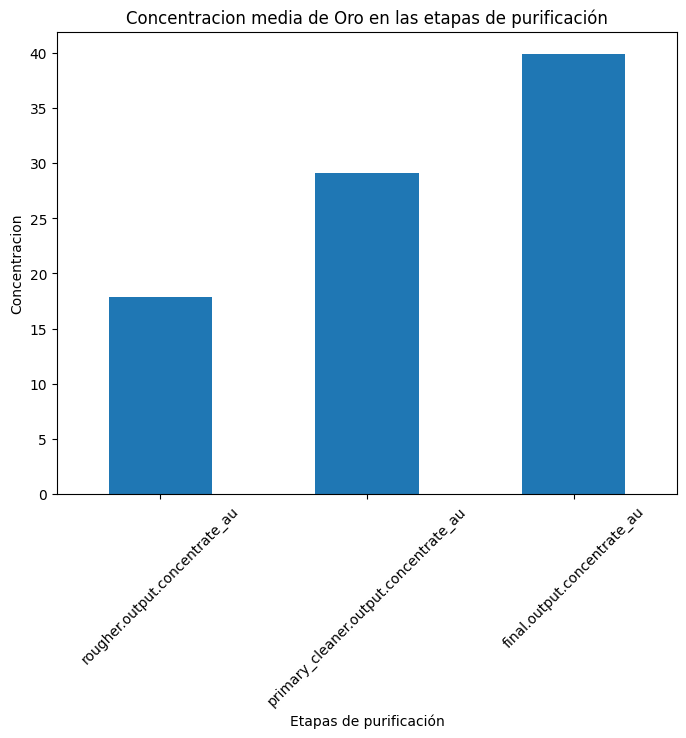

In [37]:
columnas_a_graficar_au = ['rougher.output.concentrate_au', 'primary_cleaner.output.concentrate_au', 'final.output.concentrate_au']
medias_au = gold_recovery_full_interpolate[columnas_a_graficar_au].mean()

# Usando matplotlib
plt.figure(figsize=(8, 6))  # Ajustar el tamaño de la figura
medias_au.plot(x=medias_au.index,y=medias_au.values, kind="bar", legend=False, rot=45)  # Diagrama de barras
plt.xlabel("Etapas de purificación")
plt.ylabel("Concentracion")
plt.title("Concentracion media de Oro en las etapas de purificación")
plt.show()

Podemos ver que en promedio la concentracion de Oro aumenta que es obviamente lo que se busca en la extraccion de oro, que dicha cantidad aumente en cada proceso.

Concentracion de Ag

In [38]:
print('El promedio de concentracion de Ag al entrar al proceso de purificacion es:',gold_recovery_full_interpolate['rougher.output.concentrate_ag'].mean())
print('El promedio de concentracion de Ag al salir del primer proceso de purificacion y entrar al segundo proceso de purificacion es:',gold_recovery_full_interpolate['primary_cleaner.output.concentrate_ag'].mean())
print('El promedio de concentracion de Ag al salir del segundo proceso de purificacion es:',gold_recovery_full_interpolate['final.output.concentrate_ag'].mean())


El promedio de concentracion de Ag al entrar al proceso de purificacion es: 10.841311863691667
El promedio de concentracion de Ag al salir del primer proceso de purificacion y entrar al segundo proceso de purificacion es: 7.665443598490426
El promedio de concentracion de Ag al salir del segundo proceso de purificacion es: 4.768775628068517


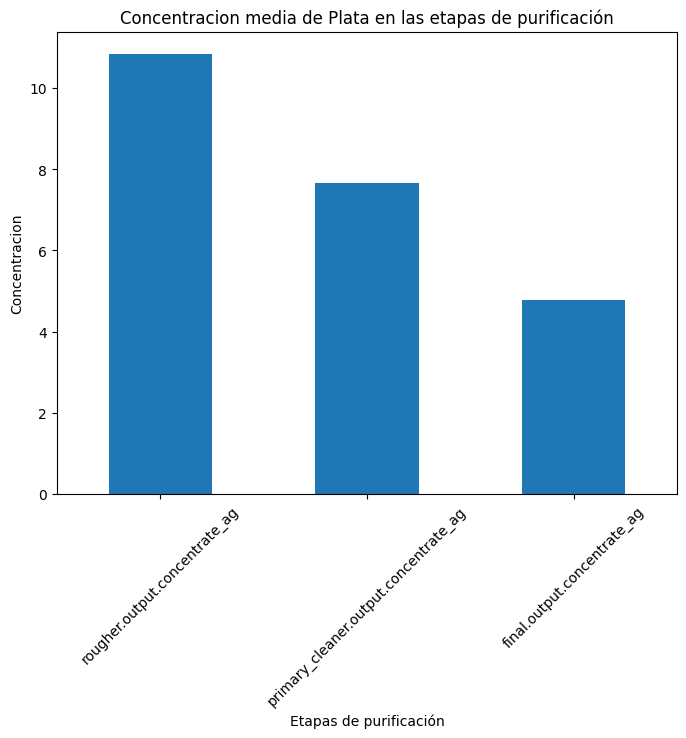

In [39]:
columnas_a_graficar_ag = ['rougher.output.concentrate_ag', 'primary_cleaner.output.concentrate_ag', 'final.output.concentrate_ag']
medias_ag = gold_recovery_full_interpolate[columnas_a_graficar_ag].mean()

# Usando matplotlib
plt.figure(figsize=(8, 6))  # Ajustar el tamaño de la figura
medias_ag.plot(x=medias_ag.index, y=medias_ag.values, kind="bar", legend=False, rot=45)  # Diagrama de barras
plt.xlabel("Etapas de purificación")
plt.ylabel("Concentracion")
plt.title("Concentracion media de Plata en las etapas de purificación")
plt.show()

La disminucion en la concentracion media de plata en el proceso de purificacion es una consecuencia del objetivo principal que es la mayor obtencion de oro al final de la purificacion, no de plata, por lo tanto la mayoria de la concentracion de plata debe estan en las colas.

Concentracion de Pb

In [40]:
print('El promedio de concentracion de Ag al entrar al proceso de purificacion es:',gold_recovery_full_interpolate['rougher.output.concentrate_pb'].mean())
print('El promedio de concentracion de Ag al salir del primer proceso de purificacion y entrar al segundo proceso de purificacion es:',gold_recovery_full_interpolate['primary_cleaner.output.concentrate_pb'].mean())
print('El promedio de concentracion de Ag al salir del segundo proceso de purificacion es:',gold_recovery_full_interpolate['final.output.concentrate_pb'].mean())


El promedio de concentracion de Ag al entrar al proceso de purificacion es: 6.881760357246065
El promedio de concentracion de Ag al salir del primer proceso de purificacion y entrar al segundo proceso de purificacion es: 8.820110633960534
El promedio de concentracion de Ag al salir del segundo proceso de purificacion es: 9.070941385371528


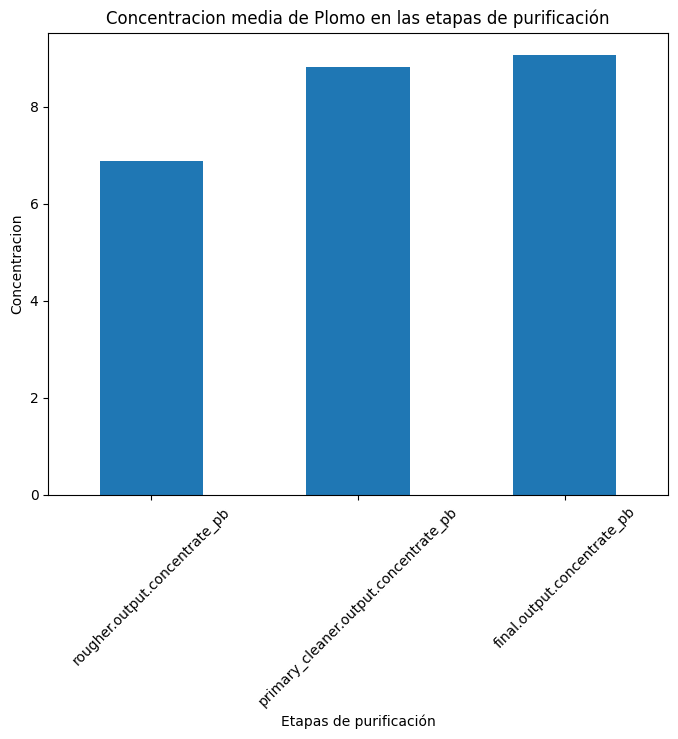

In [41]:
columnas_a_graficar_pb = ['rougher.output.concentrate_pb', 'primary_cleaner.output.concentrate_pb', 'final.output.concentrate_pb']
medias_pb = gold_recovery_full_interpolate[columnas_a_graficar_pb].mean()

# Usando matplotlib
plt.figure(figsize=(8, 6))  # Ajustar el tamaño de la figura
medias_pb.plot(x=medias_pb.index, y=medias_pb.values, kind="bar", legend=False, rot=45)  # Diagrama de barras
plt.xlabel("Etapas de purificación")
plt.ylabel("Concentracion")
plt.title("Concentracion media de Plomo en las etapas de purificación")
plt.show()

Al contrario de la Plata el Plomo aumenta con el paso por las etapas de purificacion posiblemente sea porque al ser el segundo material mas denso de los tres se mantiene en asenso su concentracion en los procesos de purificacion.

Distribucion del tamaño de las particulas de la alimentacion

Distribucion en el flotacion

Primero vamos a revisar los valores de media y desviacion estandar para ver si las distribuciones del tamaño de las particulas de la alimentacion varia significativamente con estos datos.

In [42]:
gold_recovery_train_interpolate['rougher.input.feed_size'].describe()

count    16860.000000
mean        59.152776
std         26.131277
min          9.659576
25%         47.540138
50%         54.029671
75%         65.272775
max        484.967466
Name: rougher.input.feed_size, dtype: float64

In [43]:
gold_recovery_test_interpolate['rougher.input.feed_size'].describe()

count    5856.000000
mean       55.886800
std        22.704970
min         0.046369
25%        43.865121
50%        49.964796
75%        61.615634
max       477.445473
Name: rougher.input.feed_size, dtype: float64

Hasta aca podemos ver que tanto la media como la desviacion estandar presentan valores diferentes con lo que podriamos conciderar que las distribuciones son diferentes a pesar que los valores varian 4 unidades, aun asi tambien vamos a analisarlo de forma grafica.

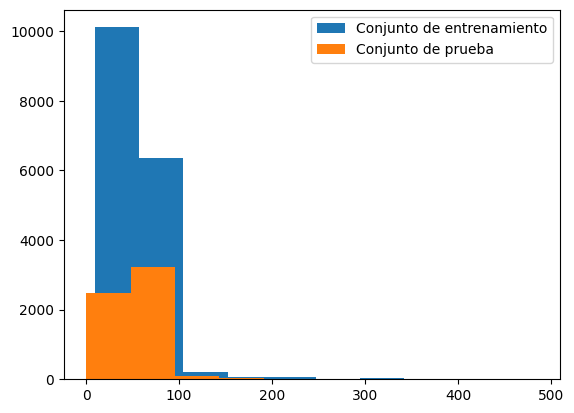

In [44]:
plt.hist(gold_recovery_train_interpolate['rougher.input.feed_size'], label='Conjunto de entrenamiento')
plt.hist(gold_recovery_test_interpolate['rougher.input.feed_size'], label='Conjunto de prueba')
plt.legend(loc='upper right')
plt.show()

Graficamente vemos que los valores en el eje x varian poco, la mayoria se encuentran entre 0 y 100, mostrando que no hay una variacion significativa en rango de valores, lo que en verdad varia en esta graficas es el valor de la frecuencia (eje vertical "y") ya que el conjunto de entrenamiento tiene mas cantidad de valores. Podriamos decir que no hay una varianza significativa pero considerare hallar el porcentaje entre valores de media de los conjuntos de datos para con ese valor considerar de forma matematica si hay variacion significativa. 



In [45]:
porcentaje_variacion_medias = ((gold_recovery_train_interpolate['rougher.input.feed_size'].mean()-gold_recovery_test_interpolate['rougher.input.feed_size'].mean())/gold_recovery_train_interpolate['rougher.input.feed_size'].mean())*100

In [46]:
porcentaje_variacion_medias

np.float64(5.521255650767179)

Con un 5% de variacion entre las medias podria considerar que no hay variaciones significativas entre las distribuciones de los valores del tamaño de las particulas de la alimentacion. Asi que podemos usar dichos datos en el modelo de machine learning.

Concentraciones totales de todas las sustancias en las diferentes etapas: materia prima, concentrado rougher y concentrado final. 

DataFrame Full

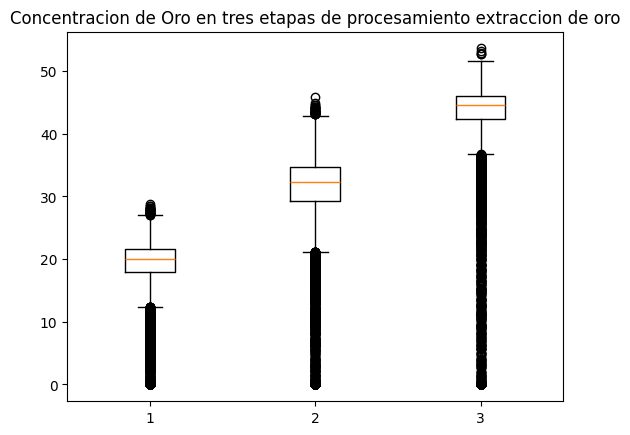

In [47]:
columnas_a_graficar_au = ['rougher.output.concentrate_au', 'primary_cleaner.output.concentrate_au', 'final.output.concentrate_au']
plt.boxplot(gold_recovery_full_interpolate[columnas_a_graficar_au])
plt.title("Concentracion de Oro en tres etapas de procesamiento extraccion de oro")
plt.show()

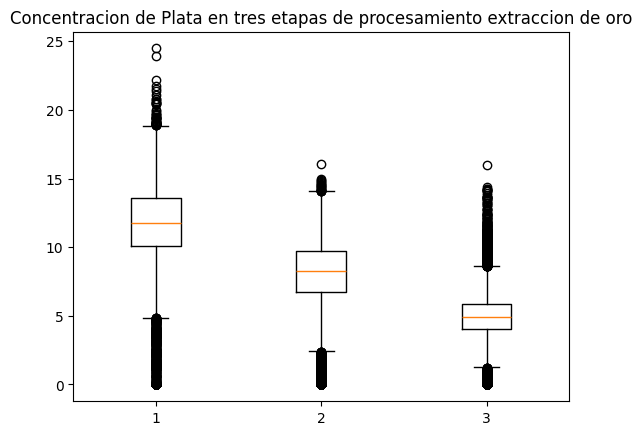

In [48]:
columnas_a_graficar_ag = ['rougher.output.concentrate_ag', 'primary_cleaner.output.concentrate_ag', 'final.output.concentrate_ag']
plt.boxplot(gold_recovery_full_interpolate[columnas_a_graficar_ag])
plt.title("Concentracion de Plata en tres etapas de procesamiento extraccion de oro")
plt.show()

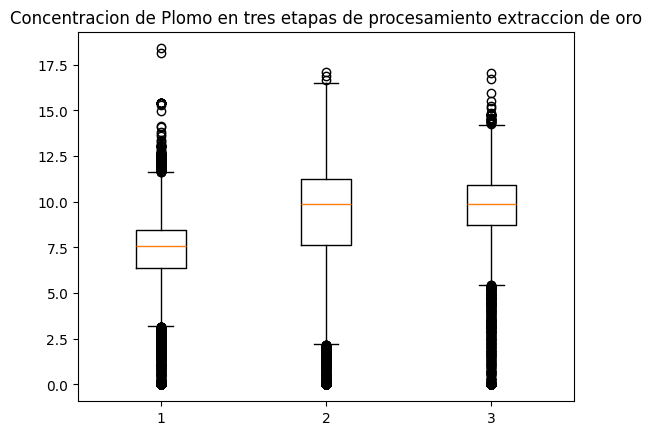

In [49]:
columnas_a_graficar_pb = ['rougher.output.concentrate_pb', 'primary_cleaner.output.concentrate_pb', 'final.output.concentrate_pb']
plt.boxplot(gold_recovery_full_interpolate[columnas_a_graficar_pb])
plt.title("Concentracion de Plomo en tres etapas de procesamiento extraccion de oro")
plt.show()

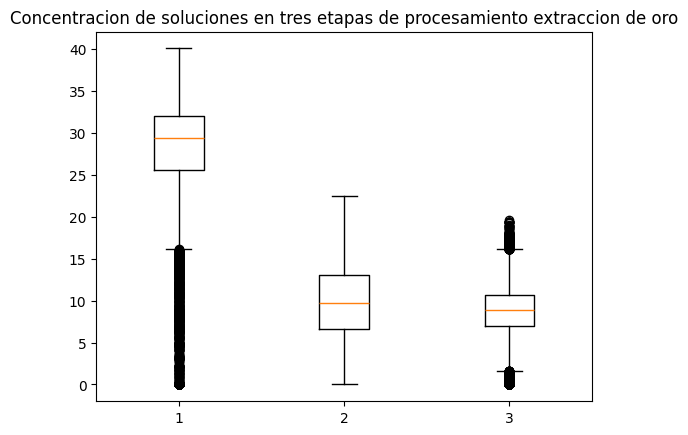

In [50]:
columnas_a_graficar_sol = ['rougher.output.concentrate_sol', 'primary_cleaner.output.concentrate_sol', 'final.output.concentrate_sol']
plt.boxplot(gold_recovery_full_interpolate[columnas_a_graficar_sol])
plt.title("Concentracion de soluciones en tres etapas de procesamiento extraccion de oro")
plt.show()

Podemos ver una gran numer ode valores atipicos en los tres metales y en las tres fases de procesamiento del oro se concidera filtrar dichos valores y trabajar con una distribucios mas homogenea en el model de marchine learning.

DataFrame train

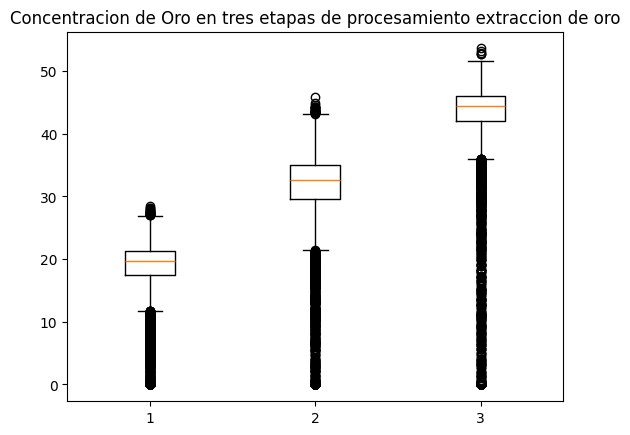

In [51]:
plt.boxplot(gold_recovery_train_interpolate[columnas_a_graficar_au])
plt.title("Concentracion de Oro en tres etapas de procesamiento extraccion de oro")
plt.show()

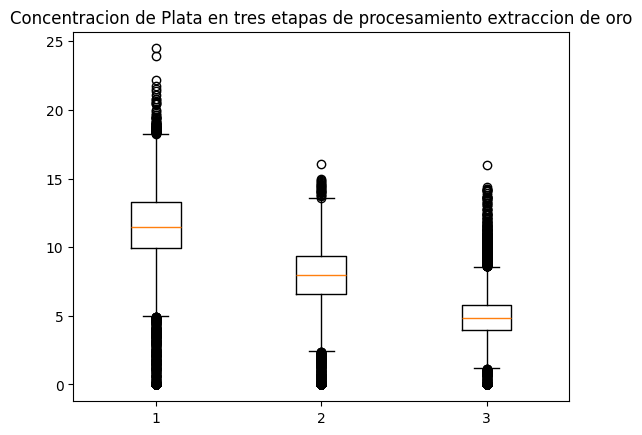

In [52]:
plt.boxplot(gold_recovery_train_interpolate[columnas_a_graficar_ag])
plt.title("Concentracion de Plata en tres etapas de procesamiento extraccion de oro")
plt.show()

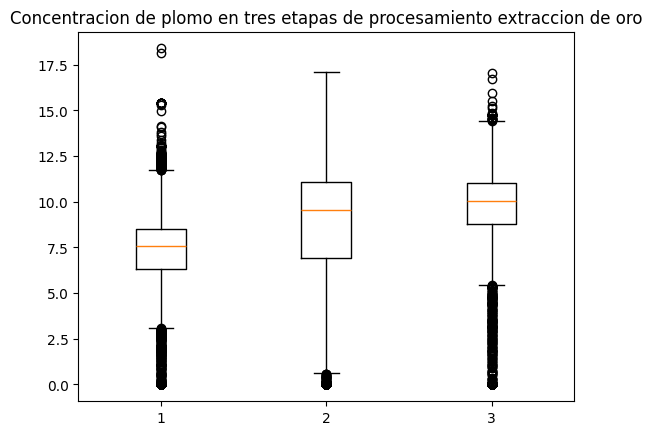

In [53]:
plt.boxplot(gold_recovery_train_interpolate[columnas_a_graficar_pb])
plt.title("Concentracion de plomo en tres etapas de procesamiento extraccion de oro")
plt.show()

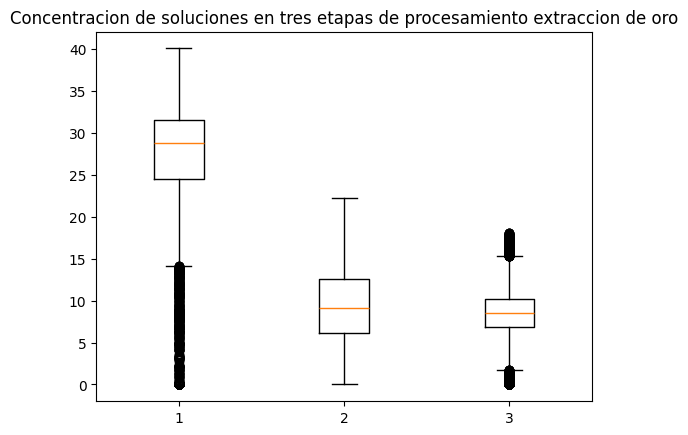

In [54]:
plt.boxplot(gold_recovery_train_interpolate[columnas_a_graficar_sol])
plt.title("Concentracion de soluciones en tres etapas de procesamiento extraccion de oro")
plt.show()

En el Dataframe de Train tambien podemos ver las concentraciones que de los tres metales y las soluciones tienen datos atipicos que podrian afectar el procedimiento con el modelo de machine learning asi que se procedera a eliminar dichos valores atipicos no solo de las columnas de concentraciones sino tambien de las columnas de recovery que utilizaremos mas adelantes como targets en el modelo de machine learning

Identificar Outliers

Usar métodos estadísticos para identificar los outliers. El método del rango intercuartílico (IQR) es comúnmente utilizado.

In [55]:
# Selecciona las catorce columnas en las que deseas eliminar outliers
columnas_objetivo = ['rougher.output.concentrate_au', 'primary_cleaner.output.concentrate_au', 'final.output.concentrate_au', 'rougher.output.concentrate_ag', 'primary_cleaner.output.concentrate_ag', 'final.output.concentrate_ag','rougher.output.concentrate_pb', 'primary_cleaner.output.concentrate_pb', 'final.output.concentrate_pb','rougher.output.concentrate_sol', 'primary_cleaner.output.concentrate_sol', 'final.output.concentrate_sol', 'rougher.output.recovery','final.output.recovery']

In [56]:
def clean_outliers (df) :
    # Calcular el IQR y los límites para cada columna objetivo
    Q1 = df[columnas_objetivo].quantile(0.25)
    Q3 = df[columnas_objetivo].quantile(0.75)
    IQR = Q3 - Q1

    # Definir los límites inferior y superior
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR

    # Crear una máscara para las filas que contienen outliers
    outliers_mask = (df[columnas_objetivo] < lower_bound) | (df[columnas_objetivo] > upper_bound)

    # Identificar las filas que contienen al menos un outlier
    outliers_mask_combined = outliers_mask.any(axis=1)

    # Eliminar las filas que contienen outliers
    df_clean = df[~outliers_mask_combined]

    return df_clean

In [57]:
gold_recovery_full_clean = clean_outliers(gold_recovery_full_interpolate)

In [58]:
gold_recovery_full_clean.head()

,date,final.output.concentrate_ag,final.output.concentrate_pb,final.output.concentrate_sol,final.output.concentrate_au,final.output.recovery,final.output.tail_ag,final.output.tail_pb,final.output.tail_sol,final.output.tail_au,primary_cleaner.input.sulfate,primary_cleaner.input.depressant,primary_cleaner.input.feed_size,primary_cleaner.input.xanthate,primary_cleaner.output.concentrate_ag,primary_cleaner.output.concentrate_pb,primary_cleaner.output.concentrate_sol,primary_cleaner.output.concentrate_au,primary_cleaner.output.tail_ag,primary_cleaner.output.tail_pb,primary_cleaner.output.tail_sol,primary_cleaner.output.tail_au,primary_cleaner.state.floatbank8_a_air,primary_cleaner.state.floatbank8_a_level,primary_cleaner.state.floatbank8_b_air,primary_cleaner.state.floatbank8_b_level,primary_cleaner.state.floatbank8_c_air,primary_cleaner.state.floatbank8_c_level,primary_cleaner.state.floatbank8_d_air,primary_cleaner.state.floatbank8_d_level,rougher.calculation.sulfate_to_au_concentrate,rougher.calculation.floatbank10_sulfate_to_au_feed,rougher.calculation.floatbank11_sulfate_to_au_feed,rougher.calculation.au_pb_ratio,rougher.input.feed_ag,rougher.input.feed_pb,rougher.input.feed_rate,rougher.input.feed_size,rougher.input.feed_sol,rougher.input.feed_au,rougher.input.floatbank10_sulfate,rougher.input.floatbank10_xanthate,rougher.input.floatbank11_sulfate,rougher.input.floatbank11_xanthate,rougher.output.concentrate_ag,rougher.output.concentrate_pb,rougher.output.concentrate_sol,rougher.output.concentrate_au,rougher.output.recovery,rougher.output.tail_ag,rougher.output.tail_pb,rougher.output.tail_sol,rougher.output.tail_au,rougher.state.floatbank10_a_air,rougher.state.floatbank10_a_level,rougher.state.floatbank10_b_air,rougher.state.floatbank10_b_level,rougher.state.floatbank10_c_air,rougher.state.floatbank10_c_level,rougher.state.floatbank10_d_air,rougher.state.floatbank10_d_level,rougher.state.floatbank10_e_air,rougher.state.floatbank10_e_level,rougher.state.floatbank10_f_air,rougher.state.floatbank10_f_level,secondary_cleaner.output.tail_ag,secondary_cleaner.output.tail_pb,secondary_cleaner.output.tail_sol,secondary_cleaner.output.tail_au,secondary_cleaner.state.floatbank2_a_air,secondary_cleaner.state.floatbank2_a_level,secondary_cleaner.state.floatbank2_b_air,secondary_cleaner.state.floatbank2_b_level,secondary_cleaner.state.floatbank3_a_air,secondary_cleaner.state.floatbank3_a_level,secondary_cleaner.state.floatbank3_b_air,secondary_cleaner.state.floatbank3_b_level,secondary_cleaner.state.floatbank4_a_air,secondary_cleaner.state.floatbank4_a_level,secondary_cleaner.state.floatbank4_b_air,secondary_cleaner.state.floatbank4_b_level,secondary_cleaner.state.floatbank5_a_air,secondary_cleaner.state.floatbank5_a_level,secondary_cleaner.state.floatbank5_b_air,secondary_cleaner.state.floatbank5_b_level,secondary_cleaner.state.floatbank6_a_air,secondary_cleaner.state.floatbank6_a_level
0,2016-01-15 00:00:00,6.055403,9.889648,5.507324,42.192020,70.541216,10.411962,0.895447,16.904297,2.143149,127.092003,10.128295,7.25,0.988759,8.547551,10.389648,19.529297,34.174427,14.936526,2.534912,7.476074,2.106679,1549.775757,-498.912140,1551.434204,-516.403442,1549.873901,-498.666595,1554.367432,-493.428131,41885.707031,3481.779053,3520.337158,2.838687,6.100378,2.284912,523.546326,55.486599,36.808594,6.486150,11.986616,6.007990,11.836743,6.005818,11.500771,7.101074,28.029297,19.793808,87.107763,5.008018,0.508728,19.154297,1.170244,999.706909,-404.066986,1603.011353,-434.715027,1602.375000,-442.204468,1598.937256,-451.294128,1404.472046,-455.462982,1416.354980,-451.939636,14.500184,4.694824,8.764648,2.606185,25.853109,-498.526489,23.893660,-501.406281,23.961798,-495.262817,21.940409,-499.340973,14.016835,-502.488007,12.099931,-504.715942,9.925633,-498.310211,8.079666,-500.470978,14.151341,-605.841980
1,2016-01-15 01:00:00,6.029369,9.968944,5.257781,42.701629,69.266198,10.462676,0.927452,16.634514,2.224930,125.629232,10.296251,7.25,1.002663,8.558743,10.

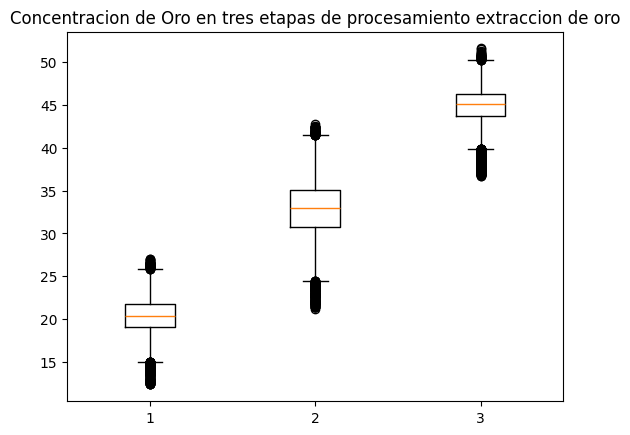

In [59]:
plt.boxplot(gold_recovery_full_clean[columnas_a_graficar_au])
plt.title("Concentracion de Oro en tres etapas de procesamiento extraccion de oro")
plt.show()

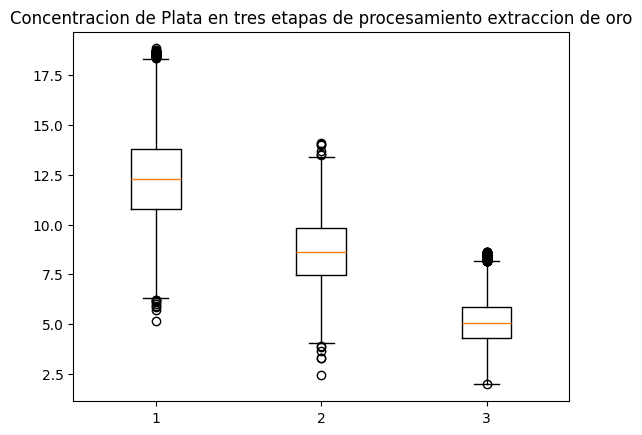

In [60]:
plt.boxplot(gold_recovery_full_clean[columnas_a_graficar_ag])
plt.title("Concentracion de Plata en tres etapas de procesamiento extraccion de oro")
plt.show()

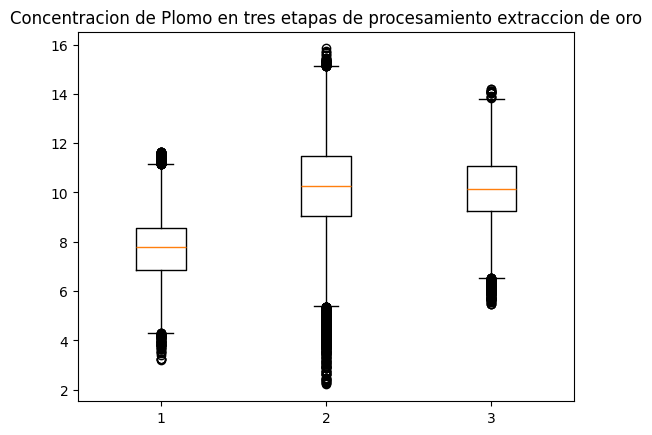

In [61]:
plt.boxplot(gold_recovery_full_clean[columnas_a_graficar_pb])
plt.title("Concentracion de Plomo en tres etapas de procesamiento extraccion de oro")
plt.show()

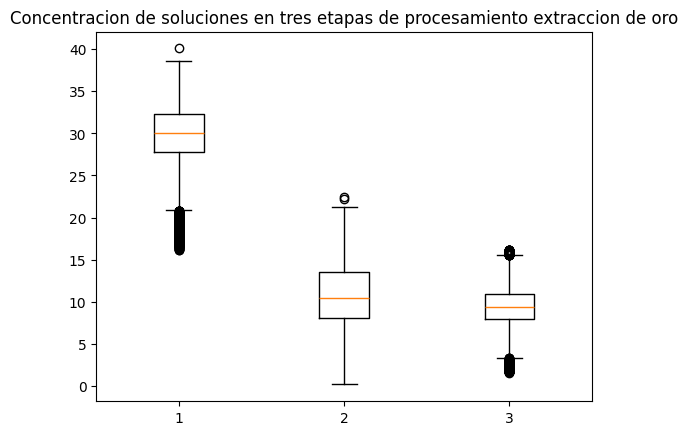

In [62]:
plt.boxplot(gold_recovery_full_clean[columnas_a_graficar_sol])
plt.title("Concentracion de soluciones en tres etapas de procesamiento extraccion de oro")
plt.show()

Se puede ver que la funcion "clean_outliers" funciono bien quitando los valores atipicos. Los valores atipicos que se ven en las nuevas graficas son los valores limite de quartiles que habia antes que en el procedimiento de la funcion ahora se consideran valores atipicos 

In [63]:
gold_recovery_train_clean = clean_outliers(gold_recovery_train_interpolate)

In [64]:
gold_recovery_train_clean.head()

,date,final.output.concentrate_ag,final.output.concentrate_pb,final.output.concentrate_sol,final.output.concentrate_au,final.output.recovery,final.output.tail_ag,final.output.tail_pb,final.output.tail_sol,final.output.tail_au,primary_cleaner.input.sulfate,primary_cleaner.input.depressant,primary_cleaner.input.feed_size,primary_cleaner.input.xanthate,primary_cleaner.output.concentrate_ag,primary_cleaner.output.concentrate_pb,primary_cleaner.output.concentrate_sol,primary_cleaner.output.concentrate_au,primary_cleaner.output.tail_ag,primary_cleaner.output.tail_pb,primary_cleaner.output.tail_sol,primary_cleaner.output.tail_au,primary_cleaner.state.floatbank8_a_air,primary_cleaner.state.floatbank8_a_level,primary_cleaner.state.floatbank8_b_air,primary_cleaner.state.floatbank8_b_level,primary_cleaner.state.floatbank8_c_air,primary_cleaner.state.floatbank8_c_level,primary_cleaner.state.floatbank8_d_air,primary_cleaner.state.floatbank8_d_level,rougher.calculation.sulfate_to_au_concentrate,rougher.calculation.floatbank10_sulfate_to_au_feed,rougher.calculation.floatbank11_sulfate_to_au_feed,rougher.calculation.au_pb_ratio,rougher.input.feed_ag,rougher.input.feed_pb,rougher.input.feed_rate,rougher.input.feed_size,rougher.input.feed_sol,rougher.input.feed_au,rougher.input.floatbank10_sulfate,rougher.input.floatbank10_xanthate,rougher.input.floatbank11_sulfate,rougher.input.floatbank11_xanthate,rougher.output.concentrate_ag,rougher.output.concentrate_pb,rougher.output.concentrate_sol,rougher.output.concentrate_au,rougher.output.recovery,rougher.output.tail_ag,rougher.output.tail_pb,rougher.output.tail_sol,rougher.output.tail_au,rougher.state.floatbank10_a_air,rougher.state.floatbank10_a_level,rougher.state.floatbank10_b_air,rougher.state.floatbank10_b_level,rougher.state.floatbank10_c_air,rougher.state.floatbank10_c_level,rougher.state.floatbank10_d_air,rougher.state.floatbank10_d_level,rougher.state.floatbank10_e_air,rougher.state.floatbank10_e_level,rougher.state.floatbank10_f_air,rougher.state.floatbank10_f_level,secondary_cleaner.output.tail_ag,secondary_cleaner.output.tail_pb,secondary_cleaner.output.tail_sol,secondary_cleaner.output.tail_au,secondary_cleaner.state.floatbank2_a_air,secondary_cleaner.state.floatbank2_a_level,secondary_cleaner.state.floatbank2_b_air,secondary_cleaner.state.floatbank2_b_level,secondary_cleaner.state.floatbank3_a_air,secondary_cleaner.state.floatbank3_a_level,secondary_cleaner.state.floatbank3_b_air,secondary_cleaner.state.floatbank3_b_level,secondary_cleaner.state.floatbank4_a_air,secondary_cleaner.state.floatbank4_a_level,secondary_cleaner.state.floatbank4_b_air,secondary_cleaner.state.floatbank4_b_level,secondary_cleaner.state.floatbank5_a_air,secondary_cleaner.state.floatbank5_a_level,secondary_cleaner.state.floatbank5_b_air,secondary_cleaner.state.floatbank5_b_level,secondary_cleaner.state.floatbank6_a_air,secondary_cleaner.state.floatbank6_a_level
0,2016-01-15 00:00:00,6.055403,9.889648,5.507324,42.192020,70.541216,10.411962,0.895447,16.904297,2.143149,127.092003,10.128295,7.25,0.988759,8.547551,10.389648,19.529297,34.174427,14.936526,2.534912,7.476074,2.106679,1549.775757,-498.912140,1551.434204,-516.403442,1549.873901,-498.666595,1554.367432,-493.428131,41885.707031,3481.779053,3520.337158,2.838687,6.100378,2.284912,523.546326,55.486599,36.808594,6.486150,11.986616,6.007990,11.836743,6.005818,11.500771,7.101074,28.029297,19.793808,87.107763,5.008018,0.508728,19.154297,1.170244,999.706909,-404.066986,1603.011353,-434.715027,1602.375000,-442.204468,1598.937256,-451.294128,1404.472046,-455.462982,1416.354980,-451.939636,14.500184,4.694824,8.764648,2.606185,25.853109,-498.526489,23.893660,-501.406281,23.961798,-495.262817,21.940409,-499.340973,14.016835,-502.488007,12.099931,-504.715942,9.925633,-498.310211,8.079666,-500.470978,14.151341,-605.841980
1,2016-01-15 01:00:00,6.029369,9.968944,5.257781,42.701629,69.266198,10.462676,0.927452,16.634514,2.224930,125.629232,10.296251,7.25,1.002663,8.558743,10.

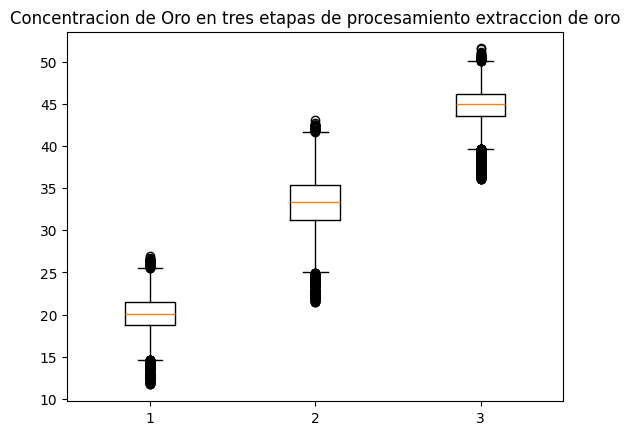

In [65]:
plt.boxplot(gold_recovery_train_clean[columnas_a_graficar_au])
plt.title("Concentracion de Oro en tres etapas de procesamiento extraccion de oro")
plt.show()

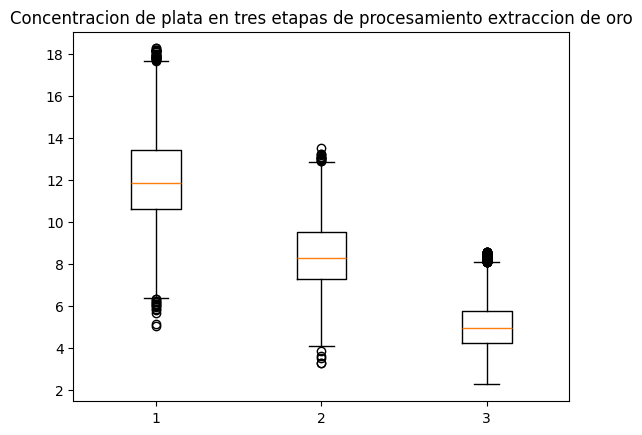

In [66]:
plt.boxplot(gold_recovery_train_clean[columnas_a_graficar_ag])
plt.title("Concentracion de plata en tres etapas de procesamiento extraccion de oro")
plt.show()

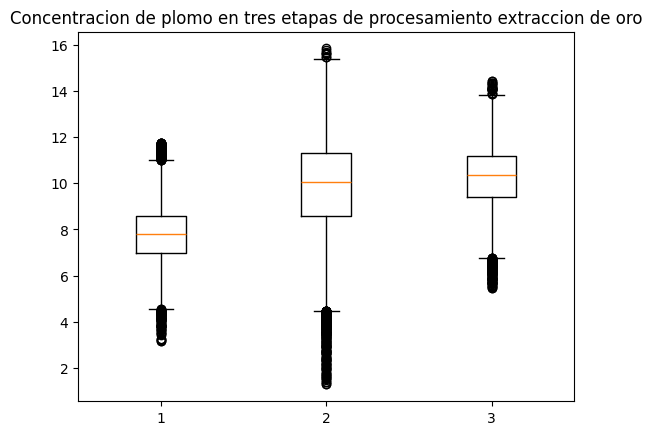

In [67]:
plt.boxplot(gold_recovery_train_clean[columnas_a_graficar_pb])
plt.title("Concentracion de plomo en tres etapas de procesamiento extraccion de oro")
plt.show()

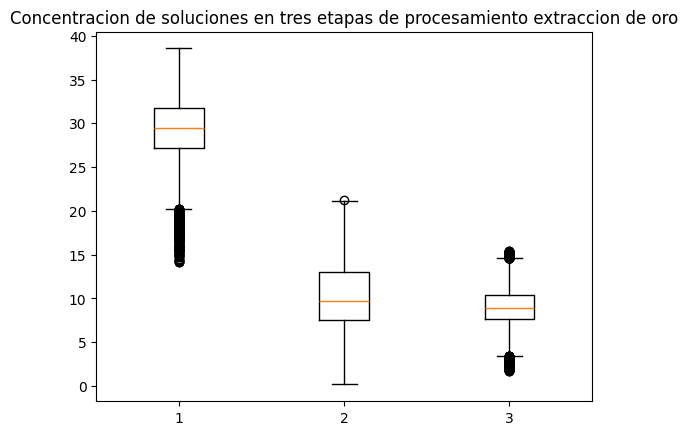

In [68]:
plt.boxplot(gold_recovery_train_clean[columnas_a_graficar_sol])
plt.title("Concentracion de soluciones en tres etapas de procesamiento extraccion de oro")
plt.show()

podemos ver que para el dataframe de entrenamiento la funcion tambien realizo su trabajo y los datos atipicos fueron quitados ahora con estos datos podemos realizar el modelo de machine learning, pero antes para los datos de test debemos completarlo con las columnas que le hacen falta 

In [209]:
gold_recovery_full_clean.shape

(16555, 87)

In [210]:
gold_recovery_train_clean.shape

(11897, 87)

In [70]:
gold_recovery_test_interpolate.shape

(5856, 53)

Verificamos el tamaño de los dataframes que vamos a combinar para definir el dataframe de test para el modelo

Luego averiguamos las columnas que tienen estos dos dataframes en comun, para hacer la union y darle al conjunto de datos de prueba las columnas que le faltan y que los datos en comun se mantengan para que el proceso de eliminar datos atipicos no se pierdan y asi el modelo de buenos resultados

In [71]:
columnas_comunes = list(set(gold_recovery_full_clean.columns).intersection(set(gold_recovery_test_interpolate.columns)))

print("Columnas comunes:", columnas_comunes)

Columnas comunes: ['rougher.input.feed_au', 'primary_cleaner.state.floatbank8_a_level', 'primary_cleaner.state.floatbank8_a_air', 'secondary_cleaner.state.floatbank3_a_air', 'rougher.input.feed_sol', 'rougher.state.floatbank10_e_air', 'primary_cleaner.input.feed_size', 'rougher.state.floatbank10_f_air', 'secondary_cleaner.state.floatbank5_a_air', 'secondary_cleaner.state.floatbank2_b_air', 'primary_cleaner.state.floatbank8_b_level', 'date', 'secondary_cleaner.state.floatbank4_b_air', 'secondary_cleaner.state.floatbank4_a_level', 'primary_cleaner.state.floatbank8_d_level', 'primary_cleaner.state.floatbank8_b_air', 'primary_cleaner.input.sulfate', 'rougher.input.floatbank11_sulfate', 'primary_cleaner.state.floatbank8_d_air', 'primary_cleaner.input.xanthate', 'rougher.state.floatbank10_c_level', 'rougher.state.floatbank10_b_air', 'secondary_cleaner.state.floatbank3_a_level', 'rougher.input.floatbank10_xanthate', 'secondary_cleaner.state.floatbank6_a_level', 'rougher.input.feed_ag', 'rough

In [72]:
gold_recovery_test_clean = gold_recovery_test_interpolate.merge(gold_recovery_full_clean,on=columnas_comunes,how='inner')

Verificamos el tamaño del dataframe final de prueba el cual solo tendra 491 datos para el proceso con el modelo.

In [73]:
gold_recovery_test_clean.shape

(487, 87)

In [74]:
gold_recovery_test_clean.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 487 entries, 0 to 486
Data columns (total 87 columns):
 #   Column                                              Non-Null Count  Dtype         
---  ------                                              --------------  -----         
 0   date                                                487 non-null    datetime64[ns]
 1   primary_cleaner.input.sulfate                       487 non-null    float64       
 2   primary_cleaner.input.depressant                    487 non-null    float64       
 3   primary_cleaner.input.feed_size                     487 non-null    float64       
 4   primary_cleaner.input.xanthate                      487 non-null    float64       
 5   primary_cleaner.state.floatbank8_a_air              487 non-null    float64       
 6   primary_cleaner.state.floatbank8_a_level            487 non-null    float64       
 7   primary_cleaner.state.floatbank8_b_air              487 non-null    float64       
 8   primary_cl

In [75]:
gold_recovery_test_clean.isna().sum()

date                                                  0
primary_cleaner.input.sulfate                         0
primary_cleaner.input.depressant                      0
primary_cleaner.input.feed_size                       0
primary_cleaner.input.xanthate                        0
primary_cleaner.state.floatbank8_a_air                0
primary_cleaner.state.floatbank8_a_level              0
primary_cleaner.state.floatbank8_b_air                0
primary_cleaner.state.floatbank8_b_level              0
primary_cleaner.state.floatbank8_c_air                0
primary_cleaner.state.floatbank8_c_level              0
primary_cleaner.state.floatbank8_d_air                0
primary_cleaner.state.floatbank8_d_level              0
rougher.input.feed_ag                                 0
rougher.input.feed_pb                                 0
rougher.input.feed_rate                               0
rougher.input.feed_size                               0
rougher.input.feed_sol                          

In [76]:
gold_recovery_test_clean.duplicated().sum()

np.int64(0)

Verificamos que no hay datos duplicados ni ausentes 

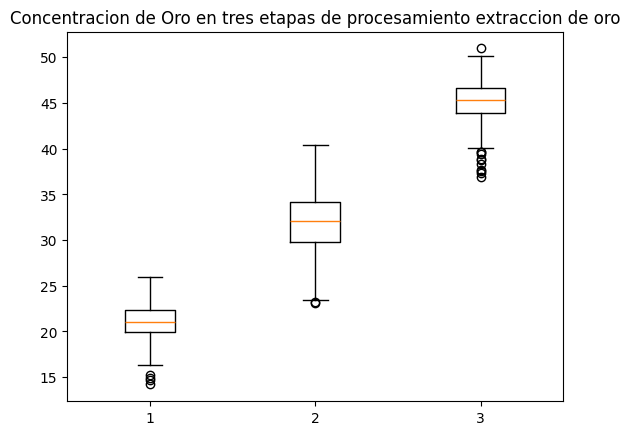

In [77]:
plt.boxplot(gold_recovery_test_clean[columnas_a_graficar_au])
plt.title("Concentracion de Oro en tres etapas de procesamiento extraccion de oro")
plt.show()

Tambien verificamos que los datos atipicos no volvieron a aparcer en el proceso de union

In [78]:
# vemos si todavian faltan completar las columnas que le hacian falta al conjunto test
cols_full_clean= list(gold_recovery_full_clean.columns)
cols_test_clean = list(gold_recovery_test_clean.columns)

# Comparar listas de columnas
cols_unique_test_clean = [col for col in cols_full_clean if col not in cols_test_clean]

print(cols_unique_test_clean)

[]


Y que hay columnas faltantes. ahora ya tenemos el conjunto de entrenamiento y tes listo para el proceso del modelo de machine learning

# 3. Contruccion del modelo

Primero se seleccionaran las columnas que anteriormente fueron procesadas para la eliminacion de valores atipicos (columnas_objetivo) como las columnas base de cada conjunto de datos (entrenamiento y prueba) para entrenar y validar la prueba final del modelo. Ya que usar todas las columnas de cada Dataframe al no estar procesadas por datos ausentes pueden causar ruido en los resultados del modelo, ademas que la columna "date" no es posible usarla en el proceso.

Se creara una funcion smape para hallar dicho valor individual segun sea la columna objetivo para despues hallar el sMAPE final con la suma de porcentajes.

Se usara un score personalizado  con la funcion "make_scorer" que me permitira utilizar la funcion "cross_validate" y dar el resultado del sMAPE para cada situacion en la que la columna objetivo o datos objetivos sean diferentes y ademas evaluar cada uno de los modelos de machine learning que deseamos probar.


In [230]:
def smape(y_true, y_pred):
    return 100 * np.mean(2 * np.abs(y_true - y_pred) / (np.abs(y_true) + np.abs(y_pred)))

gold_recovery_train_clean_final = gold_recovery_train_clean[columnas_objetivo]

features = gold_recovery_train_clean_final.drop(['rougher.output.recovery'],axis=1)
target = gold_recovery_train_clean_final['rougher.output.recovery']

smape_scorer = make_scorer(smape, greater_is_better=False)
model = DecisionTreeRegressor(random_state=12345)
cv_results = cross_validate(model, features, target, cv=5, scoring=smape_scorer)

print("sMAPE scores:", -cv_results['test_score'])
print("Mean sMAPE:", -cv_results['test_score'].mean())

sMAPE scores: [7.51199988 6.41925436 6.80144913 5.02296345 5.61118322]
Mean sMAPE: 6.27337000898359


In [231]:
smape_scorer = make_scorer(smape, greater_is_better=False)
model = RandomForestRegressor(random_state=12345)
cv_results = cross_validate(model, features, target, cv=5, scoring=smape_scorer)

print("sMAPE scores:", -cv_results['test_score'])
print("Mean sMAPE:", -cv_results['test_score'].mean())

sMAPE scores: [5.30076208 5.14655026 4.38454653 3.79486631 4.58817138]
Mean sMAPE: 4.642979311807437


In [236]:
smape_scorer = make_scorer(smape, greater_is_better=False)
model = LinearRegression()
cv_results = cross_validate(model, features, target, cv=5, scoring=smape_scorer)

print("sMAPE scores:", -cv_results['test_score'])
print("Mean sMAPE:", -cv_results['test_score'].mean())

sMAPE scores: [5.09657413 5.14307964 3.12301725 3.66363756 4.70668071]
Mean sMAPE: 4.346597858004571


En el siguiente contexto

valores o columna objetivo: 'rougher.output.recovery'

Se realizo la validacion cruzada con 5 folds y metrica para evaluar sMAPE. Dando como ganador al modelo de Regresion Lineal, cabe decir que no se ajustaron los hiperparametros de los modelos Arbol de decisiones y Bosque Aleatorio que podrian mejorar en sus valores de sMAPE especialmente el Bosque Aleatorio que esta bastante cerca de la Regresion lineal, lo unico malo es el tiempo que demora en dar el resultado el Bosque aleatorio que fue de mas de 1 minuto y medio 

In [249]:
gold_recovery_train_clean_final = gold_recovery_train_clean[columnas_objetivo]

features = gold_recovery_train_clean_final.drop(['final.output.recovery'],axis=1)
target = gold_recovery_train_clean_final['final.output.recovery']

smape_scorer = make_scorer(smape, greater_is_better=False)
model = DecisionTreeRegressor(random_state=12345)
cv_results = cross_validate(model, features, target, cv=5, scoring=smape_scorer)

print("sMAPE scores:", -cv_results['test_score'])
print("Mean sMAPE:", -cv_results['test_score'].mean())

sMAPE scores: [11.10996237  9.78669815  8.21833168  8.65070204  9.70738071]
Mean sMAPE: 9.494614989844504


In [242]:
smape_scorer = make_scorer(smape, greater_is_better=False)
model = RandomForestRegressor(random_state=12345)
cv_results = cross_validate(model, features, target, cv=5, scoring=smape_scorer)

print("sMAPE scores:", -cv_results['test_score'])
print("Mean sMAPE:", -cv_results['test_score'].mean())

sMAPE scores: [6.64222603 5.79924118 5.80102585 6.2665678  8.1875389 ]
Mean sMAPE: 6.539319953667063


In [247]:
smape_scorer = make_scorer(smape, greater_is_better=False)
model = LinearRegression()
cv_results = cross_validate(model, features, target, cv=5, scoring=smape_scorer)

print("sMAPE scores:", -cv_results['test_score'])
print("Mean sMAPE:", -cv_results['test_score'].mean())

sMAPE scores: [5.42662934 5.95846481 5.79022765 6.30949715 8.28751578]
Mean sMAPE: 6.3544669456508736


En el contexto

valores o columna objetivo: 'final.output.recovery'

Se realizo la validacion cruzada con 5 folds y metrica para evaluar sMAPE. Dando como ganador al modelo de Regresion Lineal, cabe decir que no se ajustaron los hiperparametros de los modelos Arbol de decisiones y Bosque Aleatorio que podrian mejorar en sus valores de sMAPE especialmente el Bosque Aleatorio que esta bastante cerca de la Regresion lineal, lo unico malo es el tiempo que demora en dar el resultado el Bosque aleatorio que fue de mas de 1 minuto y medio.

Como conclusion para este conjunto de datos la Regresion Lineal es el mejor modelo con  el menor valor sMAPE

Al no tener un modelo previamente entrenado, pero con los mejores valores de sMAPE de la Regresion Lineal, voy a entrenar y probar el modelo de Regresion Lineal con los datos de PRUEBA.

In [254]:
gold_recovery_test_clean_final = gold_recovery_test_clean[columnas_objetivo]

features = gold_recovery_test_clean_final.drop(['rougher.output.recovery'],axis=1)
target = gold_recovery_test_clean_final['rougher.output.recovery']

features_train, features_valid, target_train, target_valid = train_test_split(features, target, test_size=0.25, random_state=12345) 
# segmenta el 25% de los datos para hacer el conjunto de validación

model = LinearRegression( )# inicializa el constructor de modelos
model.fit(features_train,target_train) # entrena el modelo en el conjunto de entrenamiento
predictions_valid = model.predict(features_valid) 

smape_rougher_output_recovery = smape(target_valid,predictions_valid)

In [255]:
smape_rougher_output_recovery

np.float64(2.716060856771382)

In [256]:
features = gold_recovery_test_clean_final.drop(['final.output.recovery'],axis=1)
target = gold_recovery_test_clean_final['final.output.recovery']

features_train, features_valid, target_train, target_valid = train_test_split(features, target, test_size=0.25, random_state=12345) 
# segmenta el 25% de los datos para hacer el conjunto de validación

model = LinearRegression( )# inicializa el constructor de modelos
model.fit(features_train,target_train) # entrena el modelo en el conjunto de entrenamiento
predictions_valid = model.predict(features_valid) 

smape_final_output_recovery = smape(target_valid,predictions_valid)

In [257]:
smape_final_output_recovery

np.float64(4.460733658166487)

In [258]:
smape_final = 0.25*smape_rougher_output_recovery+0.75*smape_final_output_recovery

In [259]:
smape_final

np.float64(4.024565457817711)

Pudimos ver que el modelo de Regresion Lineal trabajo incluso mejor con los datos de prueba que con los de entrenamiento, dandonos unas metricas de evaluacion menores que en el de entrenamiento. 

En el contexto columna objetivo 'rougher.output.recovery' con un valor de sMAPE de 2.71% demostro que el modelo esta realizando muy buenas predicciones y en el contexto columna objetivo 'final.output.recovery' con un valor de 4.4% reafirma su buena capacidad de prediccion. Y dando un sMAPE final de tan solo 4%.

Este modelo esta realizando un proceso muy bueno con errores en predicciones de 4% que han sido logrados por los procesos de tratamiento de datos que han dejado los datos de la mejor manera para la obtencion de dichos resultados.